<a href="https://colab.research.google.com/github/jakinng/a-PINN/blob/main/diffusion_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO (10/5):
- make sure the dirichlet/neumann boundary conditions are met

9/22:
- replace import numpy as np with jax.numpy as jnp, so it can run on the gpu
- can generate dataset with diff. initial conditions as part of learning process

Next week of 9/22:
- generate data with cg
- start implement NN, use a u-net without lower resolution/resampling stuff (will work better than CNN)
  - take in $u_t$ as input and output $u_{t+1}$

Then:
Assume we have a numerical solver $F: R^{n^2} \rightarrow R^{n^2}$, taking $u_{t_i}$ to $u_{t_{i + 1}}$. Then, we can take the loss for the NN to be an expected value, sampling over initial conditions given by a polynomial. We can take $u_0(x, y) = \sum_{|i + j| < 3} a_{ij} x^i x^j$ to be a random low-degree polynomial, with $a_{ij}$ sampled from $N(0, \sigma^2)$ where $\sigma^2$ can bigger, maybe around 5, to make it non-trivial. Then we would say the loss is $\ell(\theta) = \mathbb{E}_{u_0 \sim \text{random polynomial}} (\sum_{i = 1}^N ||F(u_{t_i}) - P_\theta(u_{t_i})||^2)$, where we can run $F$ in parallel to $P$. Here, $P$ is only unrolled one step (so it is run on the output of $F$). We would do some kind of loop where we set the loss to 0, run $F$ so $u_{t_i} = F(u_{t_{i-1}})$, run $P_\theta$ on $u_{t_i}$, the output of $F$, and update the loss $\ell$ by adding. Then we can do this multiple times for randomly sampled initial conditions.

Also can probably insert g into the CNN

## Meeting 10/6
- In order to enforce dirichlet BC, can do
-
        cg solve A(x) = u_n_bar
        where u_n_bar = u_n.at[boundary].set(0)
- ask about neumann
- decrease learning rate
- for the future: make ill-conditioned problem or nonlinear
- make the polynomials way more complicated (increase the degree of the polynomial and standard deviation), try applying relu to output to make it discontinuous, can also do fourier series with cos(xy*big constant)
    - can also only do first 10 timesteps (short trajectory ok)
- learning rate keep decreasing until it's small
    - can start with one example
Use haiku: https://github.com/google-deepmind/dm-haiku

## Meeting 10/17
- Can show anim as mp4 in the notebook
- Make a video of unrolling from NN side by side from the actual solver
- For unrolling, make the limits in colorbar same so we can compare
- Check if A is symmetric so we can actually use cg on it lol
    - use Jax to compute the transpose of A (since it's a linear operator) -- called "linear transpose" of A
- Can time the jax cg convergence and can also implement scipy and count/compare #iteraions
    - #layers in CNN -- one convolution for layer
    - each CG iteration in A calls A once (one convolution with the Laplacian)
    - need approx "#layers < #CG iterations"
- look at ADVECTION DIFFUSION equation
    - alan turing has a not relevant paper about how advection-diffusion leads to scale patterns on fish (the chemical morphology something something)

## Meeting 10/20
- Advection-diffusion equation
- https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation ignore $\nabla \cdot (vc)$ term; here $c = u$
- Isotropic nonlinear diffusion -- use $\partial u/\partial t = \nabla \cdot (d(v, c) \nabla c)$ where $d$ is a diffusion coefficient depending on $v$ and $c$
- Here let $d$ not depend on $x$ except $u$ depends on $x$. Set $d = e^{-1/|\nabla c|^2}$, so that when the gradient of c is higher, diffuse more and when the gradient is low, diffuse less (e.g. image processing where you smooth out large sections of the same color and preserve edges)
- Instead of call to cg, call to newton's method
- Implement standard Newton's method in higher dimensions https://jax.quantecon.org/newtons_method.html
- Finite volumes?

To solve iteratively, want $u_{n+1}$ to satisfy $$u_{n+1} = u_n + dt  \nabla \cdot (d(\nabla u_{n+1}) \nabla u_{n+1})$$ by taking $du/dt = (u_{n+1} - u_{n})/dt$. Then previously we would pull out the $d$ and make it linear and solve using cg. Now, we set $$F(u) = -(u-u_n) + dt \nabla \cdot (d(\nabla u) \cdot \nabla u),$$ where $u_{n+1}$ should satisfy $F(u_{n+1}) = 0$. We can solve this using Newton's method. Here $F: \mathbb{R}^{N \times N} \to \mathbb{R}^{N \times N}$.

### Newton Iterations

Then, we can iterate Newton using $x_{k+1} = x_k - [DF_{x_k}]^{-1} F(x_k)$, where $x_k, x_{k+1} \in \mathbb{R}^{N \times N}$ and $DF \in \mathbb{R}^{N \times N \times N \times N}$. Then we update until $|x_{k+1} - x_k| < \varepsilon$, where $k$ is the Newton iterations (and $n$ is the time iterations). Initialize with previous step: $x_0 = u_n$ and do updates from there ("dumb initialization") -- could even compare with "dumber initialization" $x_0 = 0$. Smart init would be $x_0 = G_\theta(u_n)$ where $G_\theta$ is the NN.

If we decrease number of iterations, it helps a lot! The reason why is because inverting an $M \times M$ matrix takes $O(M^3)$ to invert. So then this becomes $O(N^6)$.

- NN predictor might allow for doing longer timesteps (since if $u_n$ is far from $u_{n+1}$ newton's method may not converge)
- Can evaluate quality of solution by taking $F$ since $F(u_{n+1}) = 0$
- Can also try $d$ such that $d$ is pathological such as sin(x/100000)
- Goal: 1. We win if with NN #Newton iterations goes down as long as evaluating NN is not too expens 2. We also win if we can use bigger timesteps dt

This week:
- Try to understand this; Jack can help me write the Newton method
- Try timing the NN for heat equation
    - can also make dt bigger -- make $dt = 0.1$ or $dt = 0.25$ so cg has to do more iterations to see if NN is better than that or not
    - hard to get iteration NUMBER but can do avg time it(s) and plot against dt (should increase something like quadratically) -- compare no/dumb init with NN init
    ![](https://hackmd.io/_uploads/rke_b_ef6.jpg)


In [1]:
#@title Newton's Method
# Adapted from https://jax.quantecon.org/newtons_method.html
# https://wiki.math.ntnu.no/_media/tma4125/2017v/newton.pdf

# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import jax
from jax import numpy as jnp
from IPython.display import HTML # display videos

In [ ]:

def newton(f, x_0, tol = 1e-5, max_iter = 100, show = False, save_all = False):
    df = jax.jacfwd(f) # Jacobian
    error = jnp.inf
    x = x_0
    # if save_all, then save every newton iteration to plot
    if save_all:
        x_all = np.expand_dims(x, axis = 0)
    # plot_data(x.reshape(int(x.shape[0] ** 0.5), int(x.shape[0] ** 0.5)), show = True, title = "Newton x0")
    n_iter = 0
    while (error > tol):
        if n_iter >= max_iter:
            print('Max iteration reached without convergence')
            return x_n, n_iter
        dfx = df(x)
        # print(f"Shape of DF: {dfx.shape}")
        # print(f"Are there nan values in DF? {jnp.any(jnp.isnan(dfx))}")
        # print(f"Indices of nan values in DF: {jnp.argwhere(jnp.isnan(dfx))}")

        if dfx.shape == (): # 1 dimensional
            x_n = x - f(x) / dfx
        else:
            x_n = x - jnp.linalg.pinv(df(x)) @ f(x) # x_n = x - JF(x)^(-1)*f(x) # Newton's method iterative step

            # x_n = x - jnp.linalg.solve(df(x), f(x)) # at least 1d converts scalars to 1D arrays in the 1D case
        error = jnp.linalg.norm(x - x_n)
        if show:
            plot_data(x.reshape(int(x.shape[0] ** 0.5), int(x.shape[0] ** 0.5)), show = True, title = "x0")
            plot_data(x_n.reshape(int(x_n.shape[0] ** 0.5), int(x_n.shape[0] ** 0.5)), show = True, title = f"Updated x, error = {error:.4}")
        if save_all:
            x_all = np.append(x_all, x_n[None, :], axis = 0)
        n_iter += 1
        print(f'Error after iteration {n_iter}: {error}')
        x = x_n
    if save_all:
        return x_n, n_iter, x_all
    else:
        return x_n, n_iter

def plot_function_1d(f, range, label = '$f(x)$', x_label = '$x$', y_label = '$f(x)$', show = True):
    n = 100
    fontsize = 12
    x = jnp.linspace(range[0], range[1], n)
    fig, ax = plt.subplots()
    ax.plot(x, f(x), label = label)
    ax.set_xlabel(x_label, fontsize = fontsize)
    ax.set_ylabel(y_label, fontsize = fontsize)
    ax.axhline(color = 'black', linestyle = '--', linewidth = 1)
    ax.legend(fontsize = fontsize)
    if show:
        plt.show()
    return fig, ax

def newton_1d_example():
    # f = lambda x: jnp.sin(4 * (x - 1/4)) + x + x ** 20 - 3
    f = lambda x: x ** 2 - 3 * x -3
    root, n_iter = newton(f, x_0 = -3.0)
    fig, ax = plot_function_1d(f, range = (-5, 5), show = False)
    ax.plot(root, f(root), marker = 'x', color = 'red', label = f"root: {root:.4f}", markersize = 10)
    ax.legend()
    plt.show()
    print(f"Number of iterations starting from -4: {n_iter}")

    # x_0 = jnp.linspace(1, 1, 100)
    # a = newton(f, x_0 = x_0)

# newton_1d_example()

In [ ]:
#@title Newton Examples

## Example from https://jax.quantecon.org/newtons_method.html
def example2():
    def newton(f, x_0, tol=1e-5, max_iter=15):
        """
        A multivariate Newton root-finding routine.
        """
        x = x_0
        f_jac = jax.jacobian(f)
        # @jax.jit
        def q(x):
            " Updates the current guess. "
            return x - jnp.linalg.solve(f_jac(x), f(x))
        error = tol + 1
        n = 0
        while error > tol:
            n += 1
            if(n > max_iter):
                raise Exception('Max iteration reached without convergence')
            y = q(x)
            error = jnp.linalg.norm(x - y)
            x = y
            print(f'iteration {n}, error = {error}')
        return x

    dim = 5_000
    seed = 32

    # Create a random matrix A and normalize the rows to sum to one
    key = jax.random.PRNGKey(seed)
    A = jax.random.uniform(key, [dim, dim])
    s = jnp.sum(A, axis=0)
    A = A / s

    # Set up b and c
    b = jnp.ones(dim)
    c = jnp.ones(dim)
    init_p = jnp.ones(dim)

    def e(p, A, b, c):
        return jnp.exp(- A @ p) + c - b * jnp.sqrt(p)
    x_n, iter = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()


def newton_2d_example(): # from https://wiki.math.ntnu.no/_media/tma4125/2017v/newton.pdf
    def f(x):
        return jnp.array([x[0] * jnp.exp(x[1]) - 1, -x[0]**2 + x[1] - 1])
    x_0 = jnp.array([0.1, 0.1])
    x, n_iter = newton(f, x_0, tol = 10e-7, max_iter = 100)
    print(x, n_iter)
    print(f(x))

# newton_2d_example()


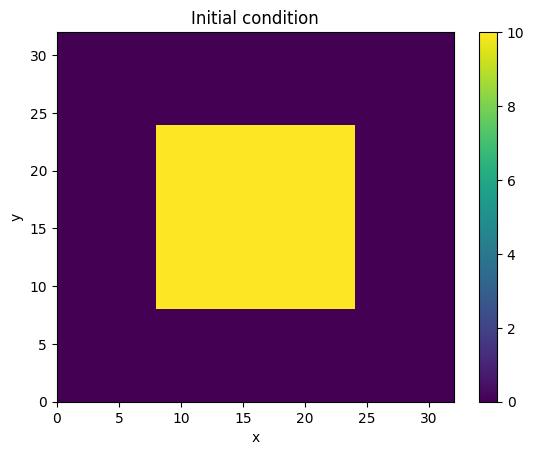

F
True


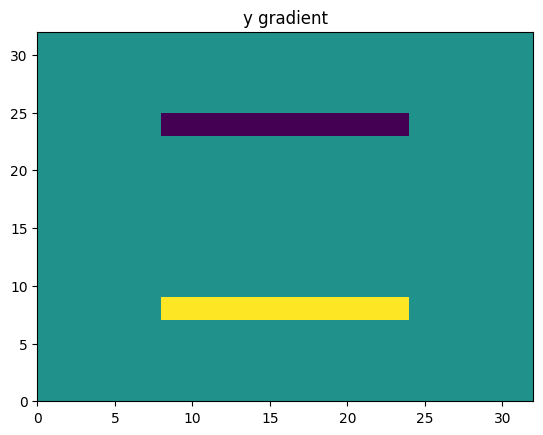

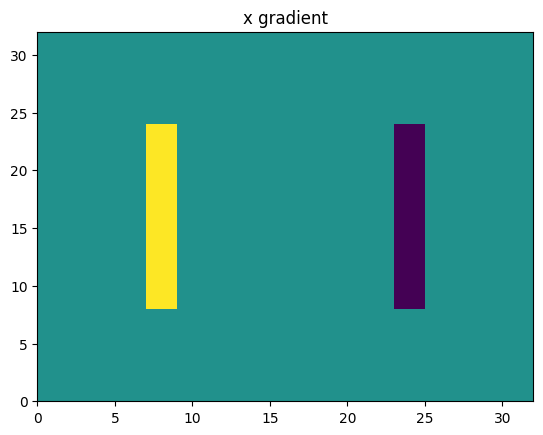

KeyboardInterrupt: 

In [ ]:
#@title Advection-Diffusion Equation

"""
Helper function returning a plot of the data
"""
def plot_data(data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
    plt.clf()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    vmin = jnp.min(data) if vmin is None else vmin
    vmax = jnp.max(data) if vmax is None else vmax
    if X is None or Y is None:
        p = plt.pcolormesh(data, vmin = vmin, vmax = vmax)
    else:
        p = plt.pcolormesh(X, Y, data, vmin = vmin, vmax = vmax)
    plt.colorbar(p)
    if show:
        plt.show()
    return plt



"""
Given u, which is initialized at u[0, :, :] with the initial conditions, use Newton's method to update and return u
with the solution of the time evolution, according to the equation

Parameters:
* initializer : initializer for Newton's method (either baseline or CNN)
"""
# Solve u
def calculate(u, dt, dx, bc = "dirichlet", method = "newton", initializer = None, tol = 1e-5, newton_max_iter = 100, show = False, animate_newton = False, plot = True, plot_newton = True):
    N_t, N_x, N_y = jnp.shape(u)
    ## Takes in and returns flat x
    def return_d(x):
        x_reshape = x.reshape(N_y, N_x)
        grad_y, grad_x = jnp.gradient(x_reshape)
        grad_norm2 = jnp.linalg.norm(jnp.array([grad_x, grad_y]), axis = 0) ** 2 # Norm-squared of the gradient
        d = jnp.exp(-1 * grad_norm2) # Diffusion coefficient
        min = np.min(d)
        max = np.max(d)
        return 0
        # return 3
    def return_velocity(x):
        v_x = 1
        v_y = 2
        return v_x, v_y
    match method:
        case "newton":
            n_iters = np.array([])
            def F(x, x_k, plot = False, equation = "advection-diffusion"):
                x_reshape = x.reshape(N_y, N_x)

                if bc == "dirichlet":
                    ## Set boundaries to zero before taking convolution for laplacian
                    x_reshape = x_reshape.at[0, :].set(0)
                    x_reshape = x_reshape.at[-1, :].set(0)
                    x_reshape = x_reshape.at[:, 0].set(0)
                    x_reshape = x_reshape.at[:, -1].set(0)

                d = return_d(x)
                lap_kernel = 1 / (dx ** 2) * jnp.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
                # op = d * dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
                if equation == "diffusion":
                    if bc == "dirichlet":
                        op = d * dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
                    elif bc == "torus":
                        op = d * dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "wrap", fillvalue = 0)

                elif equation == "grad":
                    grad_y, grad_x = jnp.gradient(x_reshape)
                    op = grad_x
                elif equation == "advection": # advection equation https://en.wikipedia.org/wiki/Advection
                    v_x, v_y = return_velocity(x_reshape)
                    grad_y1, grad_x1 = jnp.gradient(x_reshape * v_x)
                    grad_y2, grad_x2 = jnp.gradient(x_reshape * v_y)
                    op = -dt * (grad_x1 + grad_y2)
                elif equation == "advection-diffusion":
                    v_x, v_y = return_velocity(x_reshape)
                    grad_vx = jnp.gradient(x_reshape)[1] * v_x
                    grad_vy = jnp.gradient(x_reshape)[0] * v_y
                    print(plot)
                    if plot:
                        plt.pcolormesh(np.array(jnp.gradient(x_reshape)[0]) * v_y)
                        plt.title("y gradient")
                        plt.show()
                        plt.pcolormesh(np.array(jnp.gradient(x_reshape)[1]) * v_x)
                        plt.title("x gradient")
                        plt.show()

                    op = -dt * (grad_vx + grad_vy) / dx ## TODO: check sign
                    if plot:
                        plt.pcolormesh(x_reshape - op)
                        plt.title("x - op")
                        plt.show()
                    #op += d * dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)

                if bc == "dirichlet":
                    ## Set boundaries to zero before taking convolution for laplacian
                    op = op.at[(N_x - 1):, :].set(0)
                    op = op.at[:, :1].set(0)
                    op = op.at[:1, 1:].set(0)
                    op = op.at[:, (N_y - 1):].set(0)
                    # op will calculate correct value on the interior as x has zeros on the boundary, but the boundary should still be set to 0
                    # x should be zero on the boundary already from the boundary condition for the previous timestep, so x - op will still be zero on the boundary
                return (x_reshape - op - x_k.reshape(N_y, N_x)).flatten()
                # plot_data(grad_norm2, title = "Gradient norm squared", show = True)
                # plot_data(d, title = "Diffusion coefficient", show = True)

            for k in range(0, N_t - 1):
                # print(f"cg result: {jnp.asarray(jax.scipy.sparse.linalg.cg(A, u[k]))}")
                ## Plot for u[k]
                d = return_d(u[k])
                # if plot is True:
                #     grad_y, grad_x = jnp.gradient(u[k])
                #     grad_norm2 = jnp.linalg.norm(jnp.array([grad_x, grad_y]), axis = 0) ** 2 # Norm-squared of the gradient
                #     # plot_data(grad_y, title = "Gradient in y-direction", show = False)
                #     # plot_data(grad_x, title = "Gradient in x-direction", show = False)
                #     # plot_data(grad_norm2, title = "Gradient norm squared", show = False)
                #     # plot_data(d, title = "Diffusion coefficient", show = True)
                #     v_x, v_y = return_velocity(u[k])
                #     grad_y1, grad_x1 = jnp.gradient(u[k] * v_x)
                #     grad_y2, grad_x2 = jnp.gradient(u[k] * v_y)
                #     div = -1 * (grad_x1 + grad_y2)
                #     print("HELLO!!")
                #     plot_data(div, title = "Divergence", show = True)
                # Initialize iterative solver
                if initializer is not None:
                    plot_data(u[k], title = "Original", show = True)
                    x0 = initializer(np.expand_dims(np.array(u[k]), axis = (0, -1)))
                    plot_data(x0.reshape(N_y, N_x), title = "CNN prediction", show = True)
                else:
                    x0 = u[k]
                print("F")
                F(u[k].flatten(), u[k].flatten(), plot = True)

                if animate_newton:
                    u_next, n_iter, u_all = newton(lambda x: F(x.flatten(), u[k].flatten()), x0.flatten(), max_iter = newton_max_iter, tol = tol, show = plot_newton, save_all = True)
                else:
                    u_next, n_iter = newton(lambda x: F(x.flatten(), u[k].flatten()), x0.flatten(), max_iter = newton_max_iter, tol = tol, show = plot_newton)
                # plot_data(F(u_next.flatten(), u[k].flatten()).reshape(N_y, N_x), "F of Newton solution (should be zero)", show = True)
                u_next = u_next.reshape(N_y, N_x)
                print(f"{n_iter=}")
                n_iters = np.append(arr = n_iters, values = n_iter)
                print(f"{n_iters=}")
                if n_iter == newton_max_iter:
                    print("did not converge")
                    plot_data(u_next, "u[k+1]", show = True)
                    u = u[:k + 1]
                    break
                u = u.at[k + 1].set(u_next)
                plot_data(u[k + 1], show = True)
                # op will calculate correct value on the interior as x has zeros on the boundary, but the boundary should still be set to 0
        case "cg":
            animate_newton = False
            def F(x):
                x_reshape = x.reshape(N_y, N_x)
                d = return_d(x)
                lap_kernel = 1 / (dx ** 2) * jnp.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
                op = d * dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
                op = op.at[(N_x - 1):, :].set(0)
                op = op.at[:, :1].set(0)
                op = op.at[:1, 1:].set(0)
                op = op.at[:, (N_y - 1):].set(0)
                return (x_reshape - op).flatten()
            for k in range(0, N_t - 1):
                ## Plot for u[k]
                d = return_d(u[k])
                if show:
                    plot_data(d, title = "Diffusion coefficient plotted", show = True)
                # u_next, n_iter = jax.scipy.sparse.linalg.cg(lambda x: F(x.flatten()), u[k].flatten()) #, u[k].flatten()), u[k].flatten())
                u_next, n_iter = jax.scipy.sparse.linalg.cg(lambda x: F(x.flatten()), u[k].flatten())
                plot_data(F(u_next.flatten()).reshape(N_y, N_x), "F of cg solution (should be zero)")
                u_next = u_next.reshape(N_y, N_x)
                print(f"{n_iter=}")
                u = u.at[k + 1].set(u_next)
                plot_data(u[k + 1], show = True)
                # op will calculate correct value on the interior as x has zeros on the boundary, but the boundary should still be set to 0

    if animate_newton:
        return u, n_iters, u_all
    else:
        return u, n_iters

def initialize(bounds, N, max_iter_time, dx, plot = True, ic_test = 1, bc_test = 1, key = jax.random.PRNGKey(0)):
    x = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
    y = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)

    # Initialize solution: the grid of u(k, i, j)
    u = jnp.zeros((max_iter_time, N, N))
    # Initial condition everywhere inside the grid
    # Set the initial condition
    match ic_test:
        case 1:
            u = u.at[0, N // 4 : 3 * N //4, N // 4 : 3 * N // 4].set(10)
            a = 0 * jax.random.normal(key = key, shape = u[0].shape)
            u = u.at[0].set(u[0] + a)
        case 2:
            deg = 5
            a = jax.random.normal(key = key, shape = (deg, deg))
            X, Y = np.meshgrid(x, y)
            for i in range(deg):
                for j in range(deg - i):
                    u = u.at[0, :, :].set(u[0, :, :] + a[i, j] * X ** i * Y ** j)
            u += 5 * jax.random.normal(key = key)
        case 3:
            # deg = rng.integers(10, 11)
            # deg = 2
            deg = 2
            a = rng.uniform(low = 11, high = 11, size = (deg, deg, 2))
            X, Y = np.meshgrid(x, y)
            for i in range(deg):
                for j in range(deg - i):
                    u = u.at[0, :, :].set(u[0, :, :] + a[i, j, 0] * np.cos(i * X + j * Y + a[i, j, 1]) ** 2)
            a = rng.normal(scale = 1, size = u.shape)
            u = u + a
        case 4:
            deg = 3
            # deg = rng.integers(2, 3)
            # deg = 2
            a = jax.random.normal(key = key, shape = (deg, deg, 2)) + 10
            h = 1
            X, Y = np.meshgrid(x, y)
            # u = u.at[0, :, :].set(u[0, :, :] + np.cos(X))
            for i in range(deg):
                for j in range(deg - i):
                    u = u.at[0, :, :].set(u[0, :, :] + np.tanh(h * a[i, j, 0] * np.cos(i * X + j * Y + a[i, j, 1]))) # take cos^2
            noise = 0.2 * jax.random.normal(key = key, shape = u[0].shape)
            u = u.at[0].set(u[0] + noise)
            # u = u.at[0, :, :].set(u[0, :, :] + np.tanh(10 * np.cos(0 * X + 1 * Y + 0))) # take cos^2
            # a = rng.normal(scale = 1, size = u.shape)
            # u = u + a
        case 5:
            coeffs = jax.random.normal(key = key, shape = (5, 3))
            def poly(x, y):
                omegas = jnp.geomspace(0.5, 2, coeffs.shape[0])
                return jnp.sum(coeffs[:, 0] * jnp.cos(x * omegas + coeffs[:, 1]) * jnp.cos(y * omegas + coeffs[:, 2]))
            X, Y = jnp.meshgrid(x, y)
            v = jax.vmap(jax.vmap(poly))(X,Y)
            scale = 2
            v = scale * (2 * v - jnp.min(v) - jnp.max(v)) / (jnp.max(v) - jnp.min(v)) # rescale to range -10 to 10

            # clip at threshold and rescale to (-1, 1)
            threshold = 20
            v = jnp.clip(threshold * v, -scale, scale)
            u = u.at[0].set(v)

            # add noise so DF is not NAN
            noise = 0.4 * jax.random.normal(key = key, shape = u[0].shape)
            u = u.at[0].set(u[0] + noise)
            plot_data(X = X, Y = Y, data = u[0], show = True)
        case 6:
            X, Y = np.meshgrid(x, y)
            print(X)
            u = u.at[0, :, :].set(100 * (1 - ((X - np.pi) / np.pi) ** 2) * (1 - ((Y - np.pi) / np.pi) ** 2))
            noise = 10 * jax.random.normal(key = key, shape = u[0].shape)
            u = u.at[0].set(u[0] + noise)
    # Set the boundary conditions
    match bc_test:
        case "dirichlet":
            u_initial = 0
            # Boundary conditions
            u_top = 0.0
            u_left = 0.0
            u_bottom = 0.0
            u_right = 0.0
            u = u.at[0, -1, :].set(u_top)
            u = u.at[0, 0, :].set(u_bottom)
            u = u.at[0, :, 0].set(u_left)
            u = u.at[0, :, -1].set(u_right)
            # u = u.at[0, 0, :].set(u_top)
            # u = u.at[0, :, :1].set(u_left)
            # u = u.at[0, :1, 1:].set(u_bottom)
            # u = u.at[0, :, (N - 1):].set(u_right)
        case "neumann":
            u = u.at[0, (N - 1):, :].set(u[0, N - 2 : N - 1, :])
            u = u.at[0, :, :1].set(u[0, :, 1:2])
            u = u.at[0, :1, :].set(u[0, 1:2, :])
            u = u.at[0, :, (N - 1):].set(u[0, :, N - 2:N - 1])
        case "torus":
            pass
    plt = plot_data(u[0, :, :], "Initial condition")
    plt.show()
    return u, x, y

# Do the calculation here
def newton_solver(seed, save_mp4 = True, method = "newton", initializer = None, dt = 0.02, tol = 1e-5, ic_test = 5,
                  max_iter_time = 20, newton_max_iter = 100, N = 32):
    bounds = np.array([0, 2 * jnp.pi])
    L = bounds[1] - bounds[0]
    dx = L / N
    bc = "dirichlet"
    bc_test = "dirichlet"
    key = jax.random.PRNGKey(seed)
    plot_calculation = False
    plot_newton = True

    animate_newton = False # Whether to animate the Newton iterations
    # newton_max_iter = 100 # maximum number of iterations that the newton solver will run for

    u, x, y = initialize(bounds, N, max_iter_time, dx, ic_test = ic_test, bc_test = bc_test, key = key)
    if animate_newton:
        u, n_iters, u_all = calculate(u, dt = dt, dx = dx, bc = bc, method = method, initializer = initializer, tol = tol, newton_max_iter = newton_max_iter, animate_newton = True, plot = plot_calculation, plot_newton = plot_newton)
    else:
        u, n_iters = calculate(u, dt = dt, dx = dx, bc = bc, method = method, initializer = initializer, tol = tol, newton_max_iter = newton_max_iter, plot = plot_calculation, plot_newton = plot_newton)
    def animate(k, u, x = None, y = None):
        plot_data(u[k], title = f"Temperature at t = {k * dt:.3f} unit time", X = x, Y = y, vmin = jnp.min(u), vmax = jnp.max(u))

    folder = "drive/MyDrive/superUROP/2024-02-26"
    test_name = f"adv_diff_{ic_test}_{bc}_{N}x{N}_{method}_{seed}_dt{dt}"
    filename = f"{folder}/{test_name}"
    jnp.save(filename, u)
    if save_mp4:
        anim = animation.FuncAnimation(plt.figure(), lambda k: animate(k, u, x, y), frames=u.shape[0], repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 10)
        anim.save(f"{filename}.mp4", writer = FFwriter, dpi = 300)
    else:
        anim = "No animation"

    ## Animate Newton iterations
    if animate_newton:
        def animate2(k, u, x = None, y = None):
            plot_data(u[k].reshape(N, N), title = f"Newton iteration {k}", X = x, Y = y, vmin = jnp.min(u), vmax = jnp.max(u))
        anim = animation.FuncAnimation(plt.figure(), lambda k: animate2(k, u_all), frames=u_all.shape[0], repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 10)
        anim.save(f"{filename}_newton0.mp4", writer = FFwriter, dpi = 300)
    return u, anim, n_iters

# i = 0
run = True
if run:
    for i in range(0, 1):
        u_newton, anim, n_iters = newton_solver(seed = i, save_mp4 = True, method = "newton", dt = 0.5, tol = 1e-5, max_iter_time = 30, ic_test = 1)
    ## Display last anim
    HTML(anim.to_html5_video())

# u_cg, anim = newton_solver(seed = i, save_mp4 = True, method = "cg")
# ## Display last anim
# HTML(anim.to_html5_video())


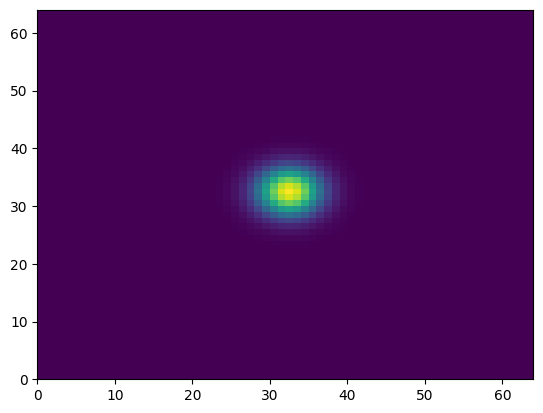

0


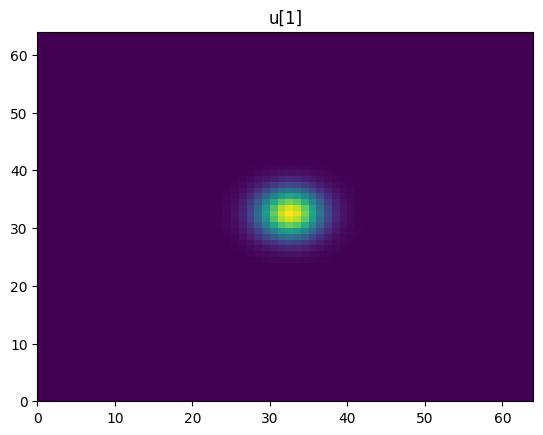

1


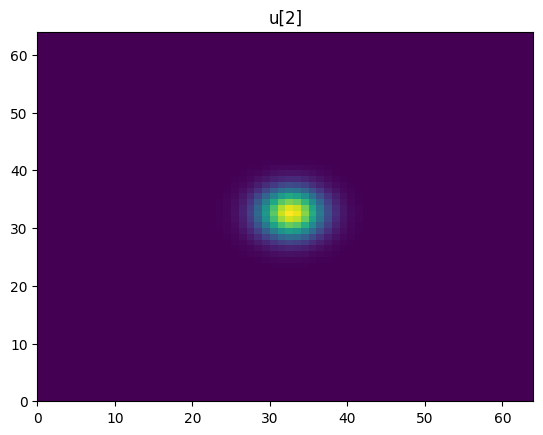

2


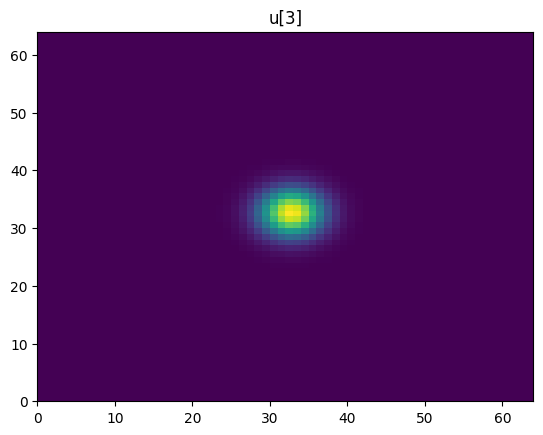

3


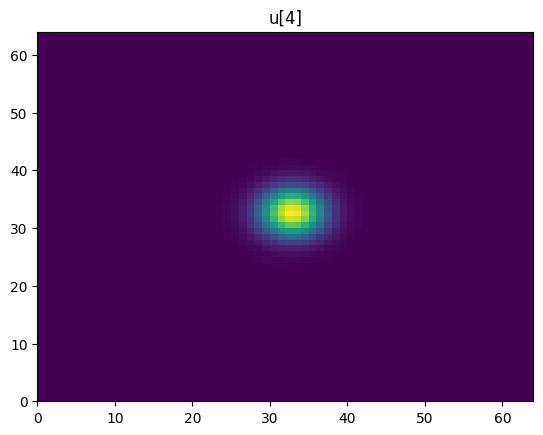

4


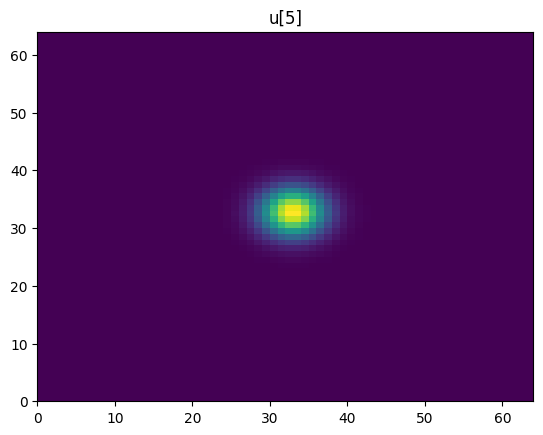

5


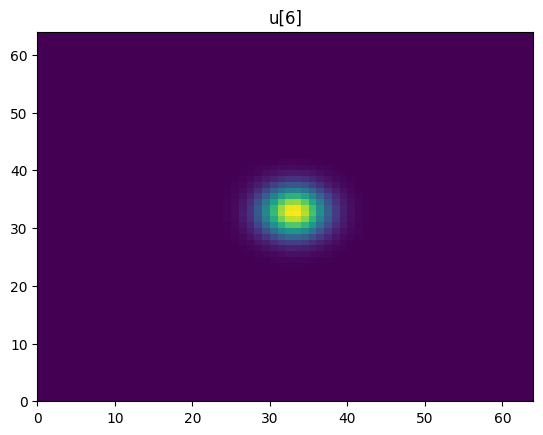

6


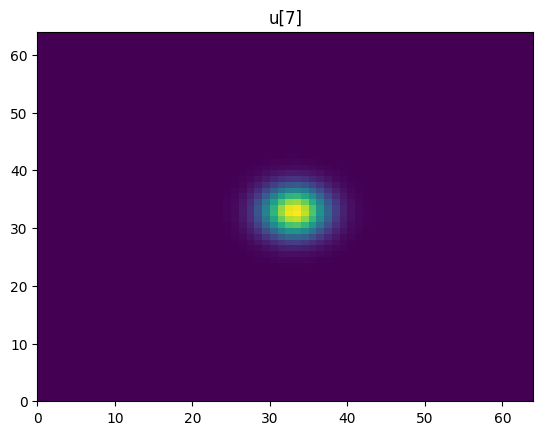

7


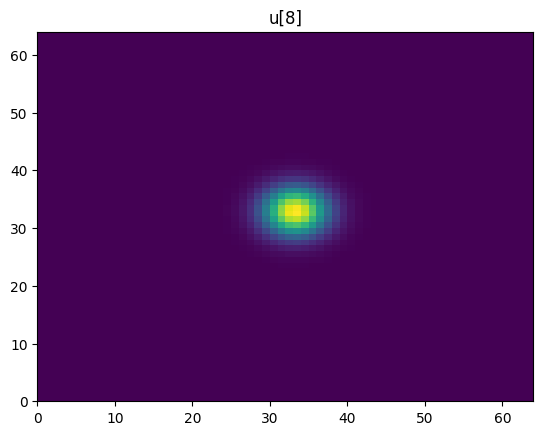

8


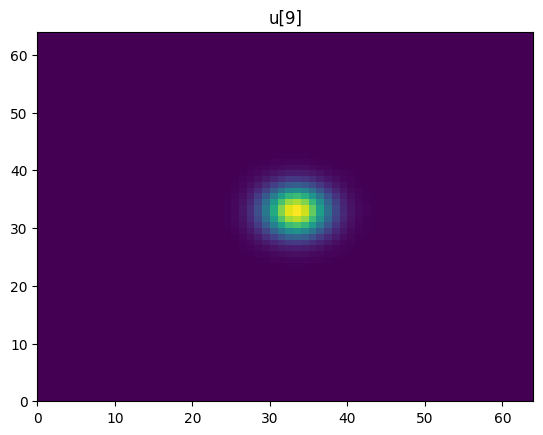

9


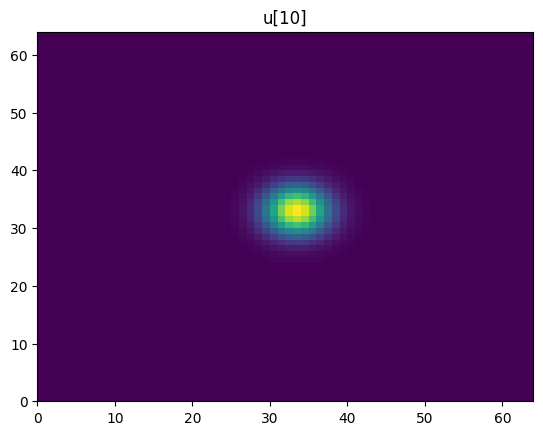

10


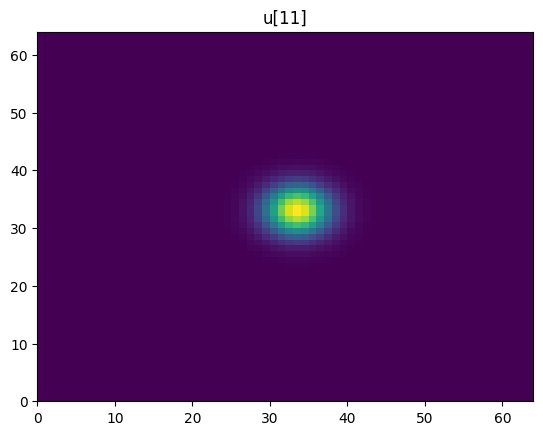

11


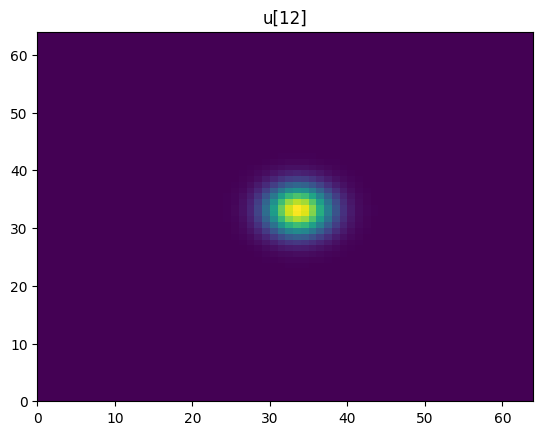

12


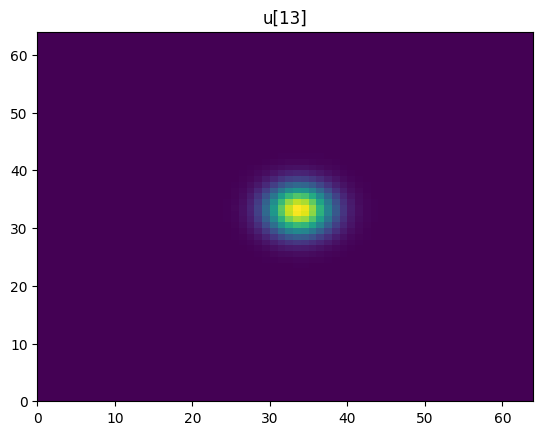

13


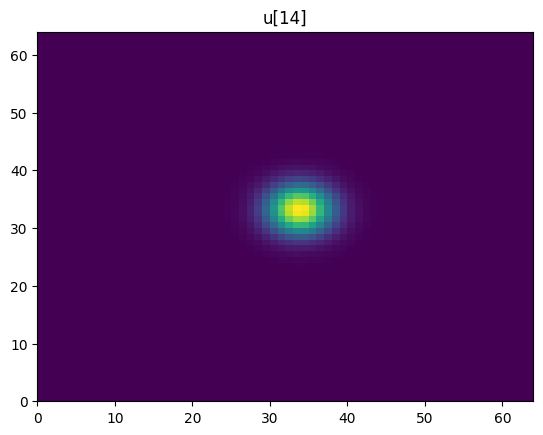

14


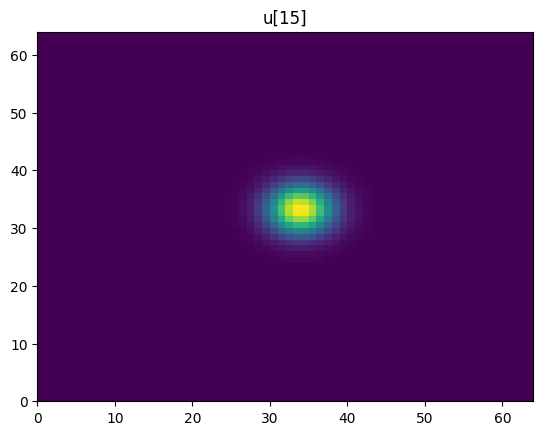

15


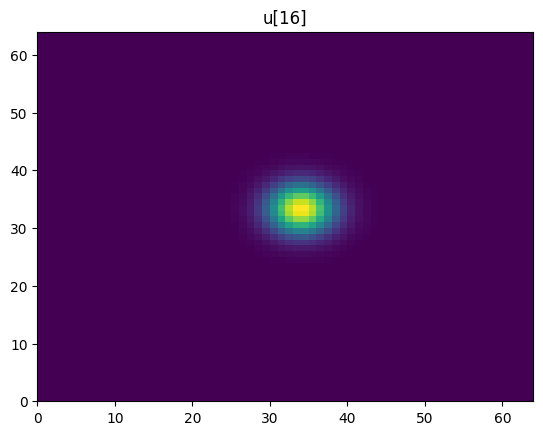

16


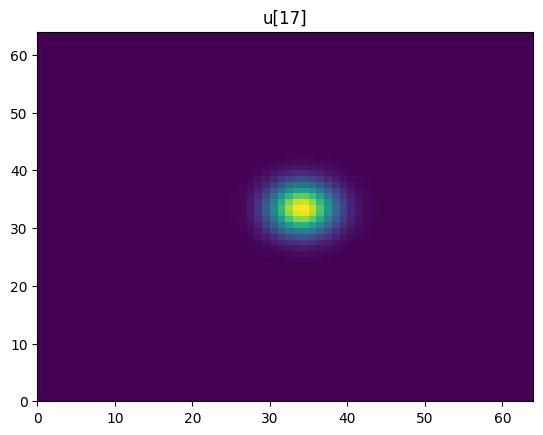

17


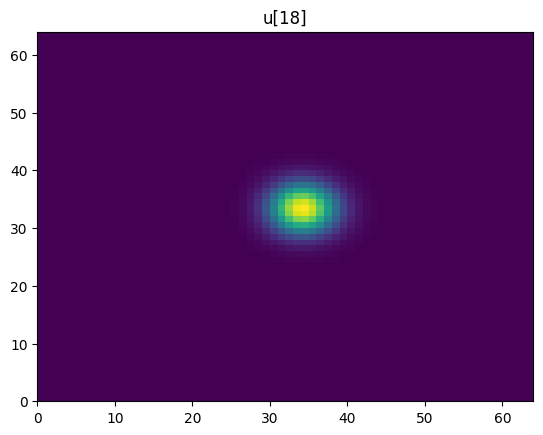

18


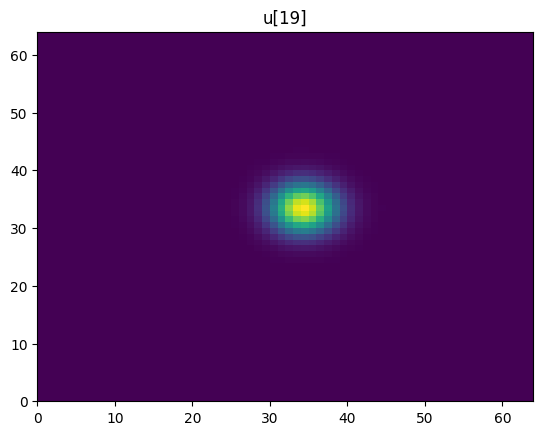

19


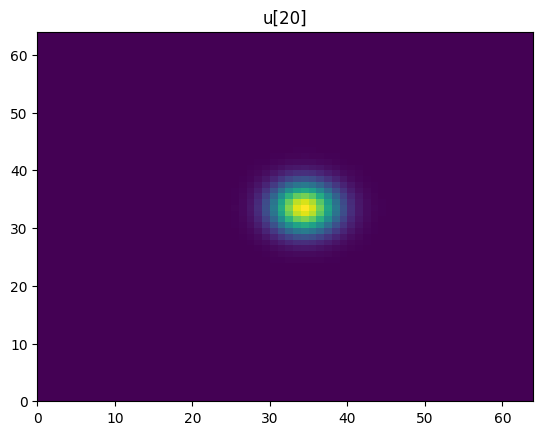

20


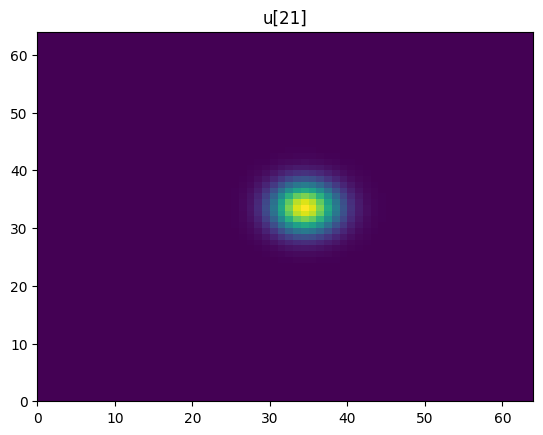

21


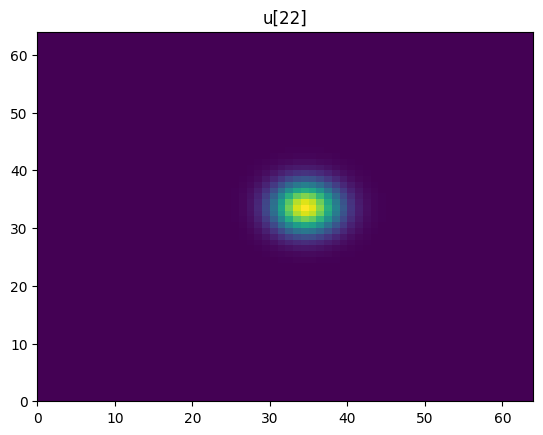

22


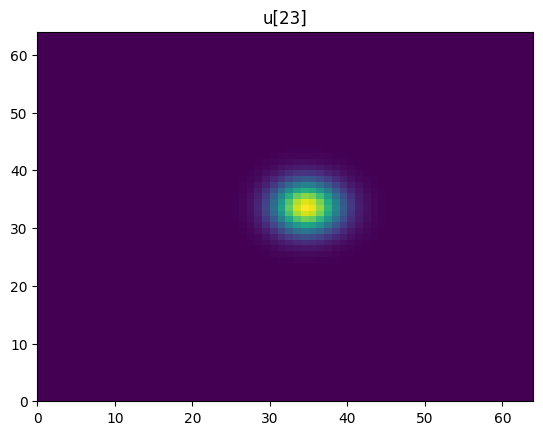

23


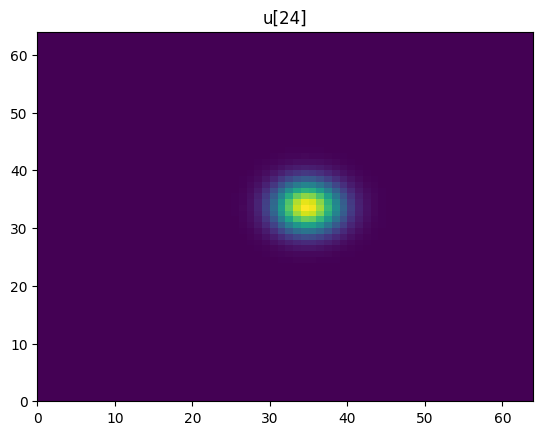

24


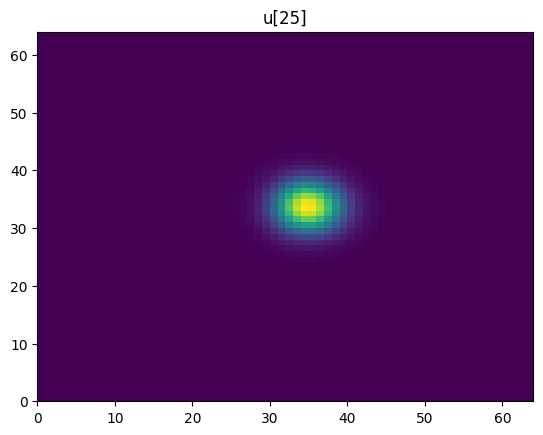

25


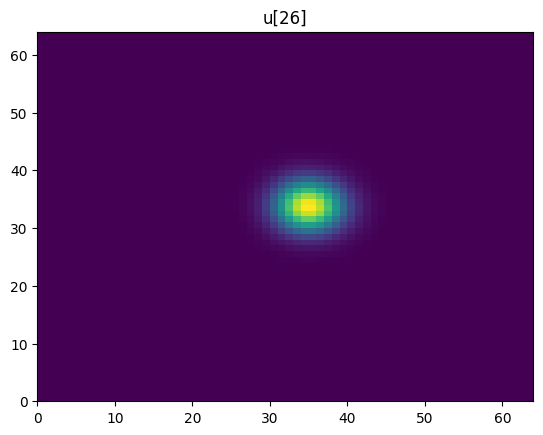

26


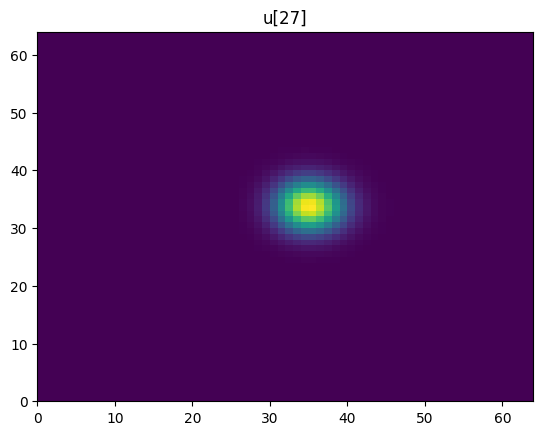

27


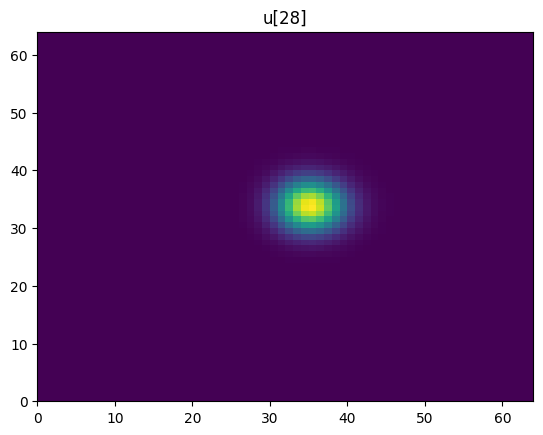

28


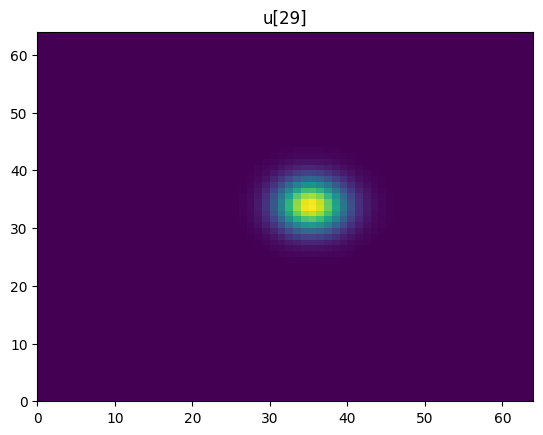

29


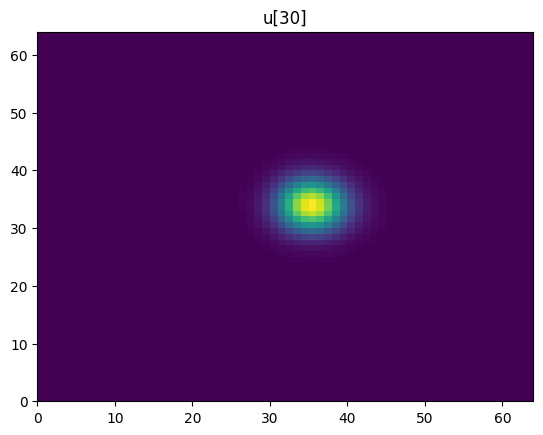

30


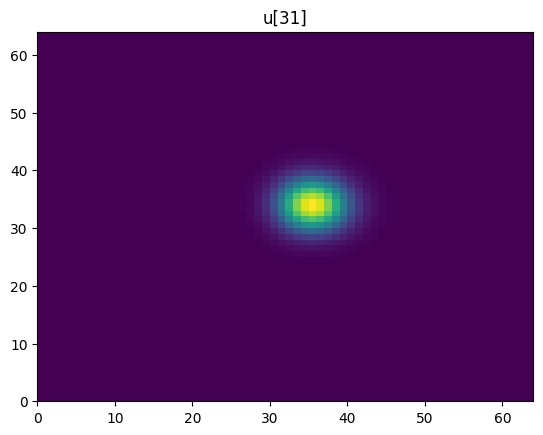

31


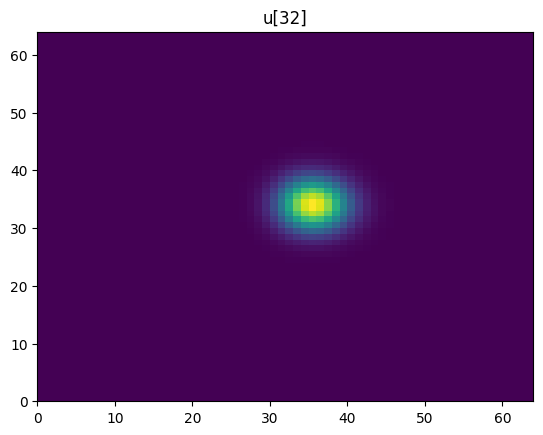

32


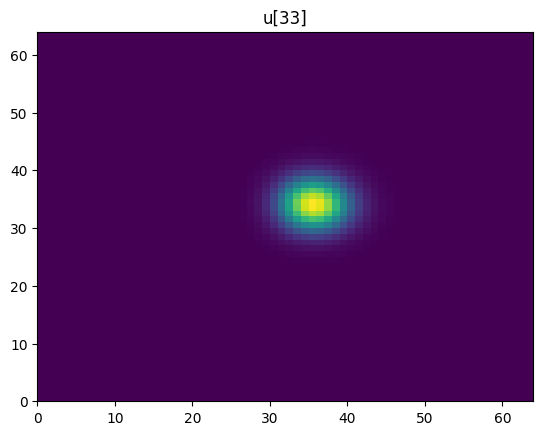

33


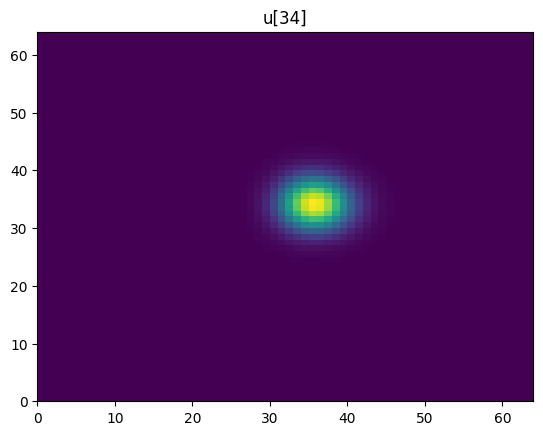

34


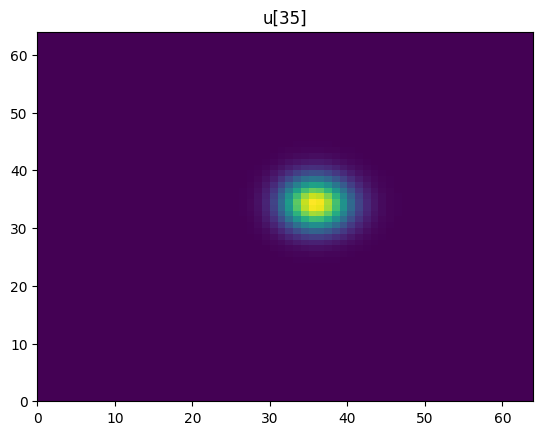

35


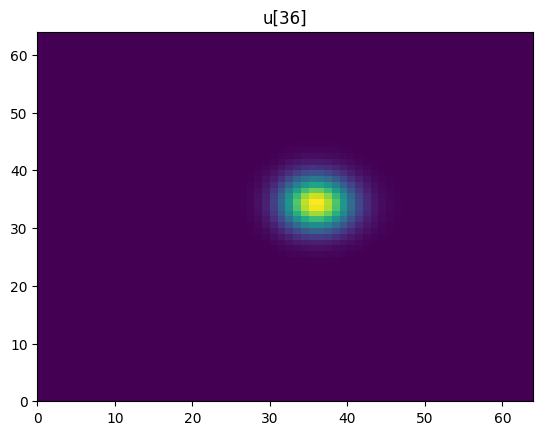

36


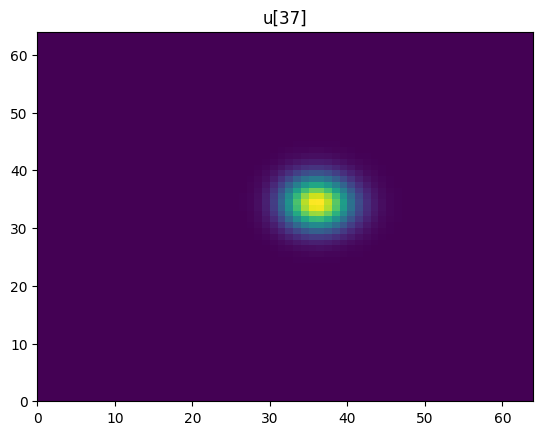

37


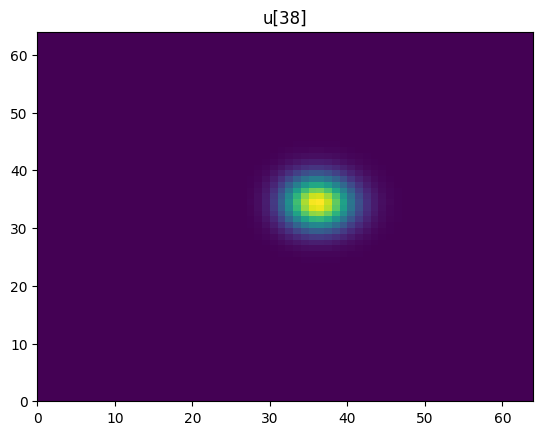

38


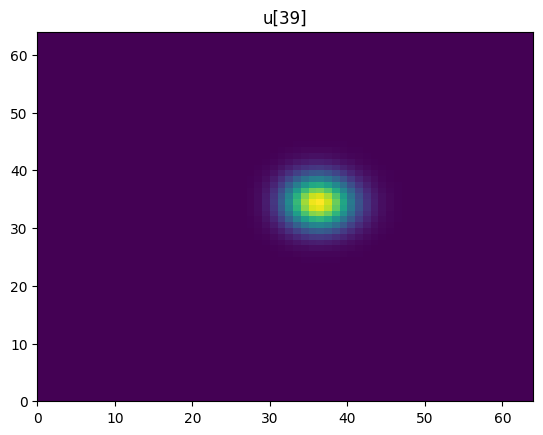

39


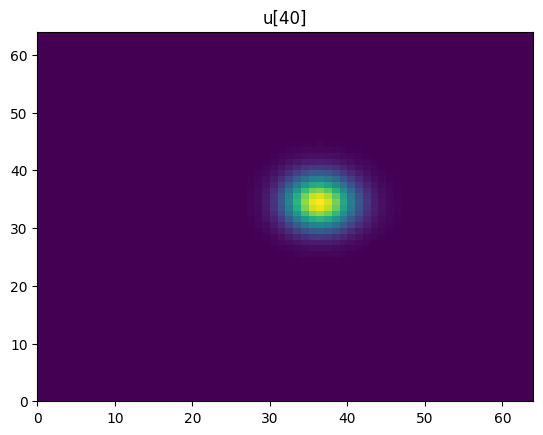

40


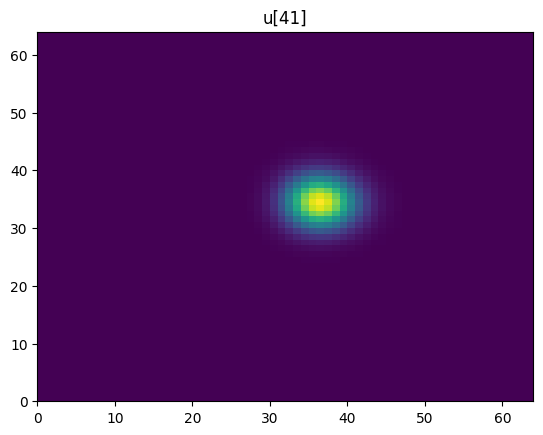

41


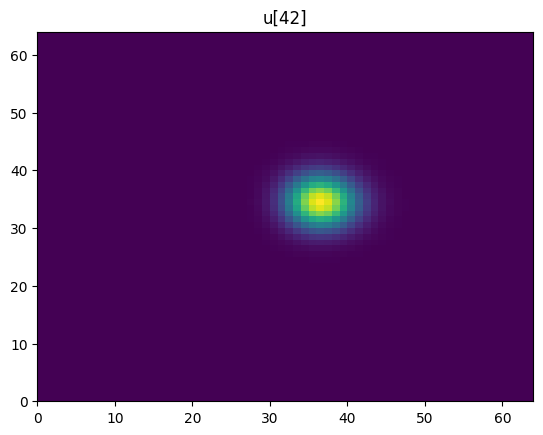

42


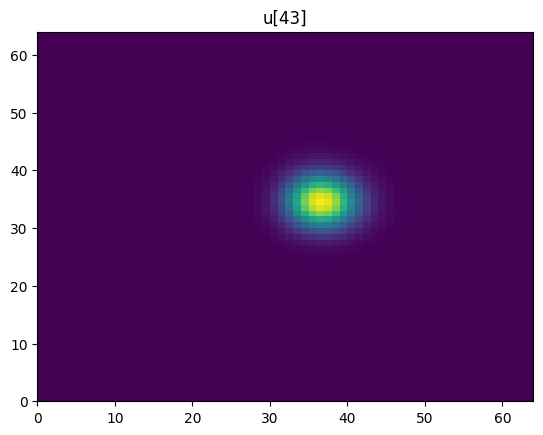

43


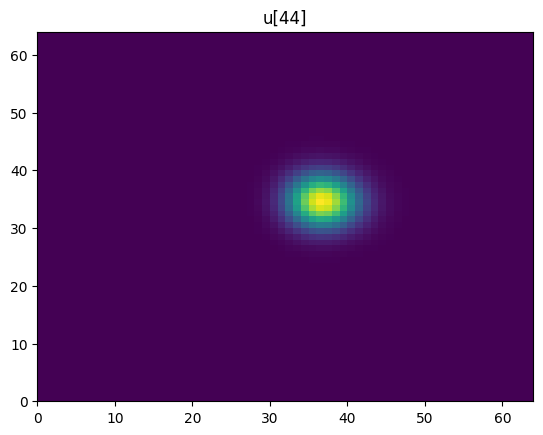

44


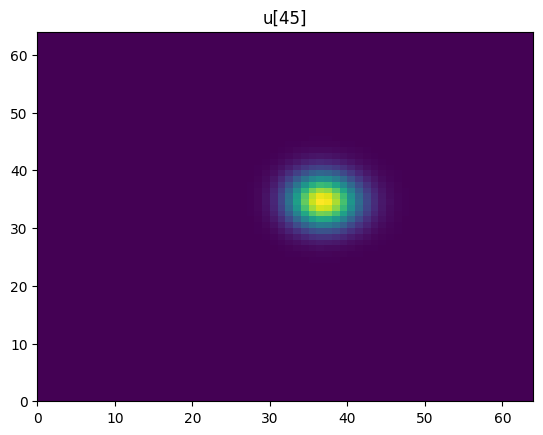

45


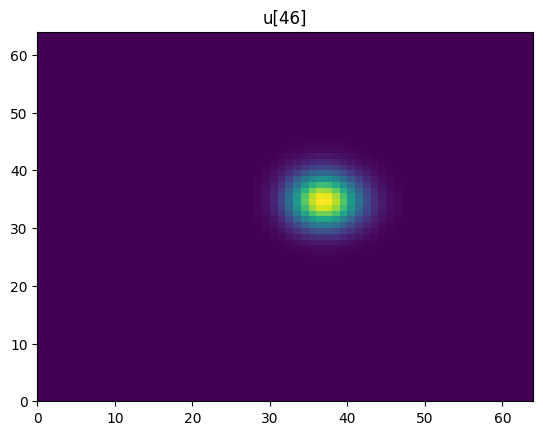

46


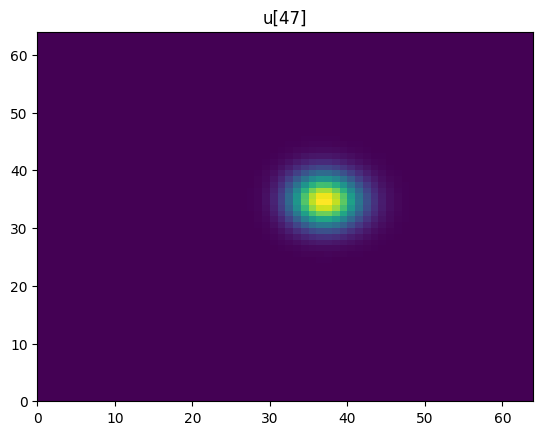

47


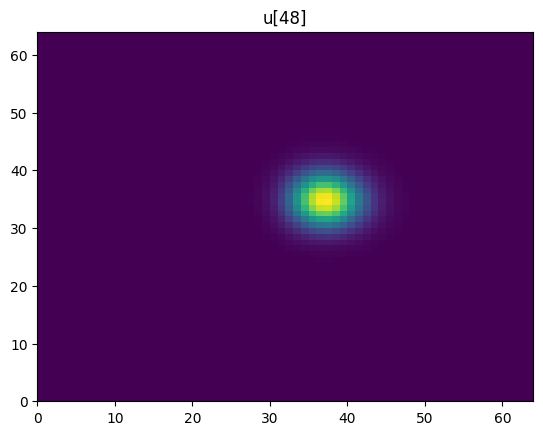

48


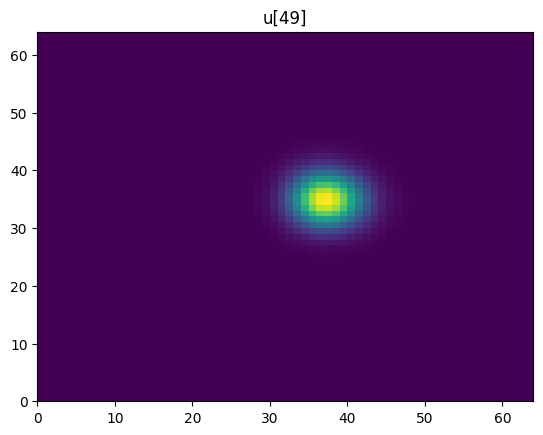

49


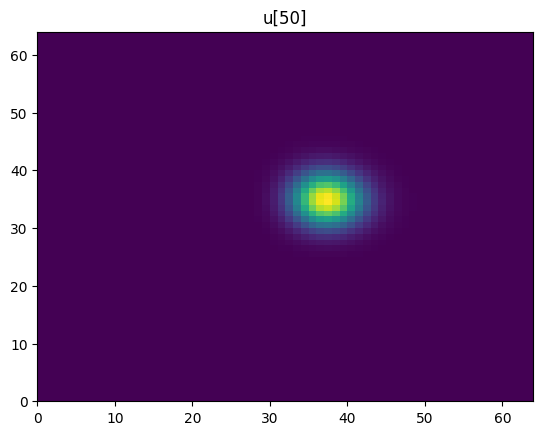

50


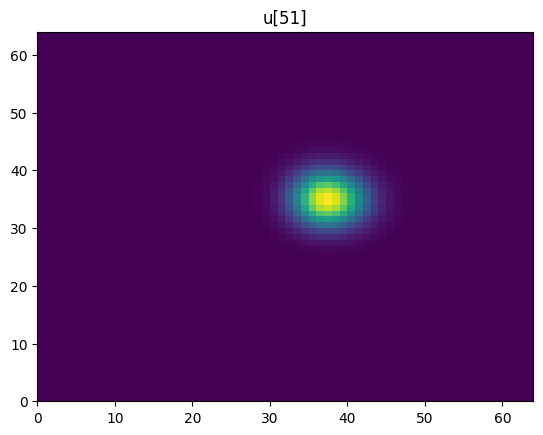

51


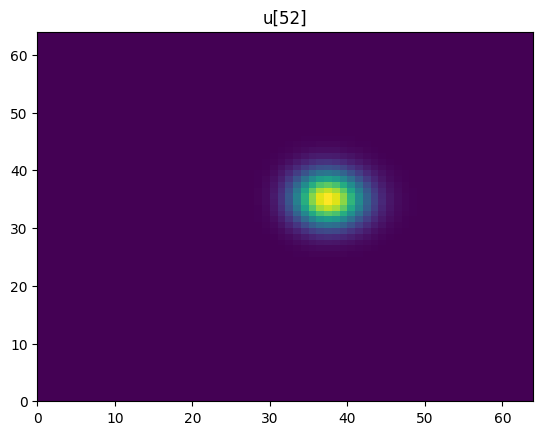

52


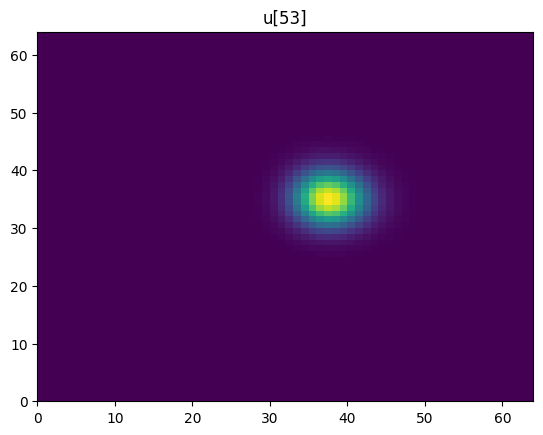

53


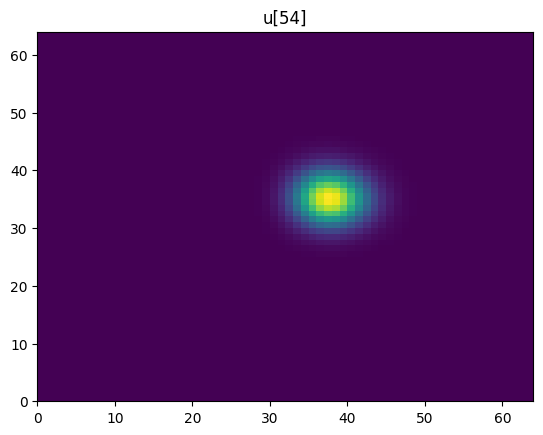

54


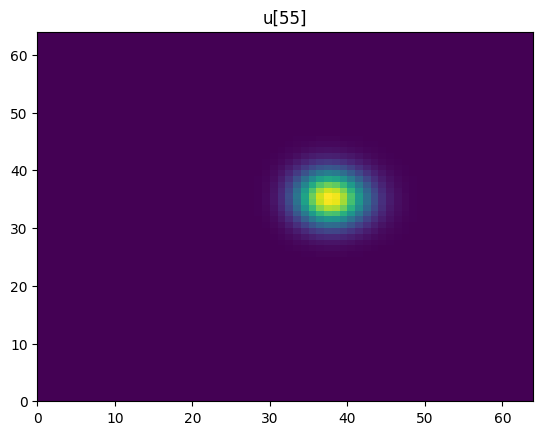

55


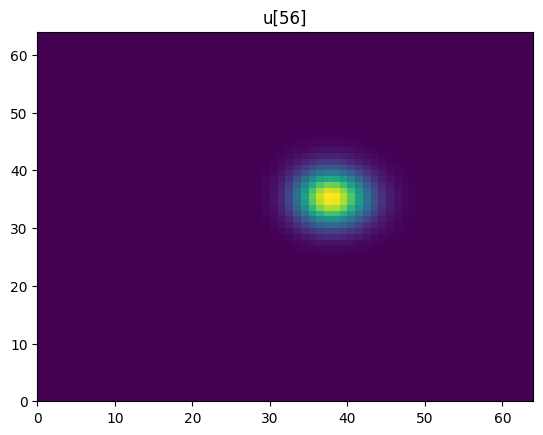

56


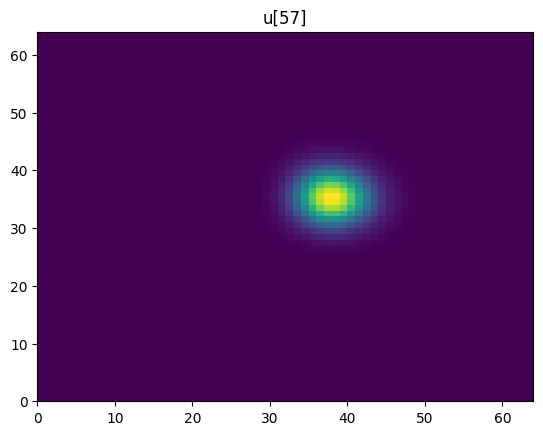

57


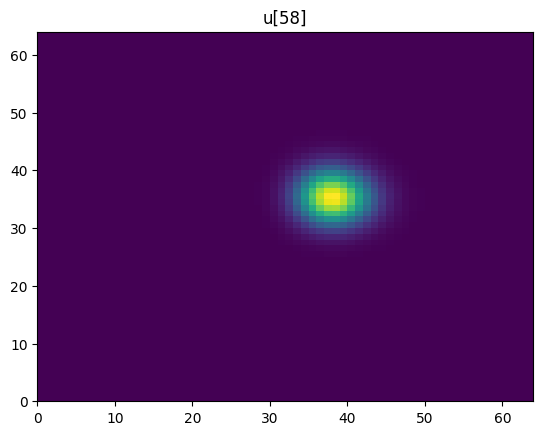

58


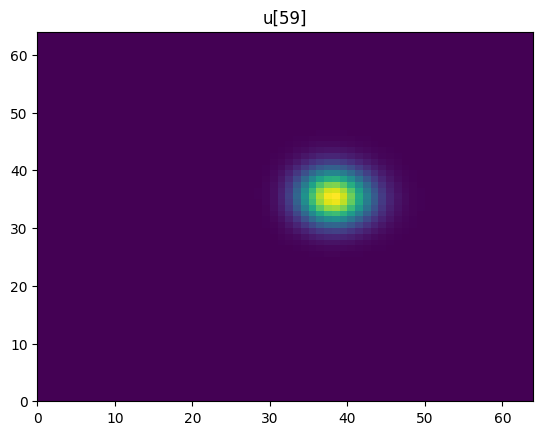

59


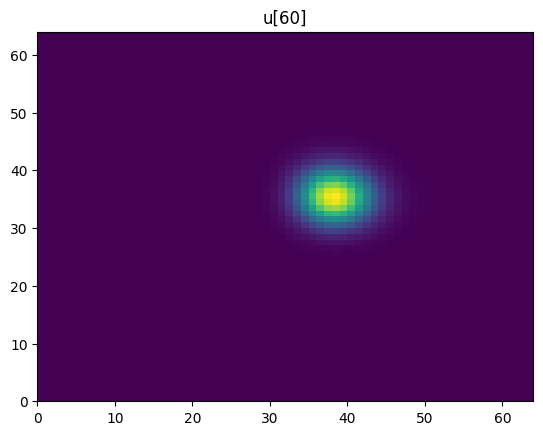

60


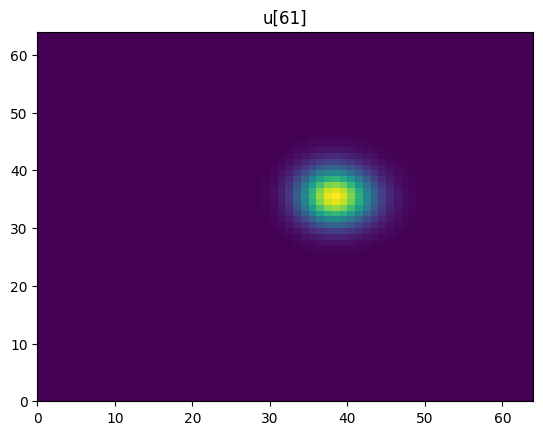

61


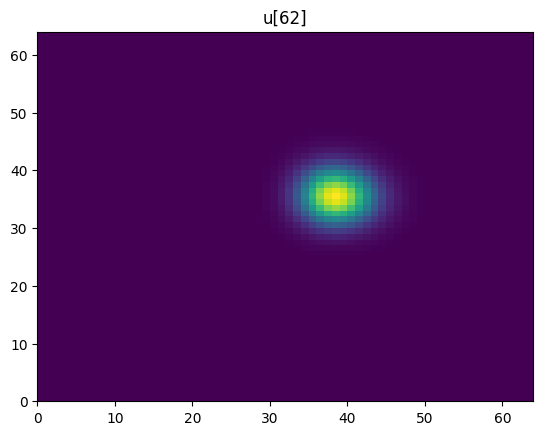

62


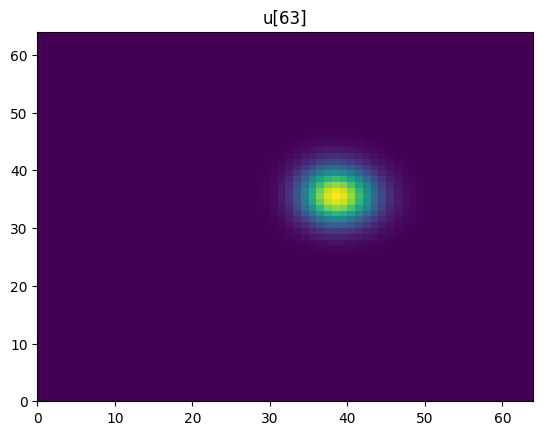

63


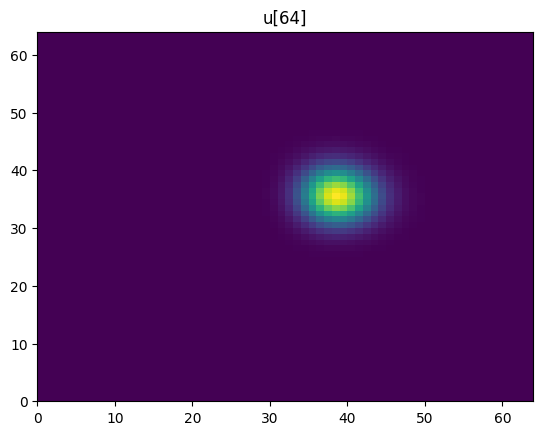

64


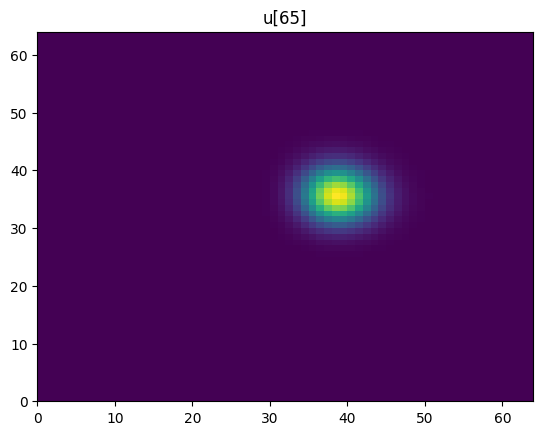

65


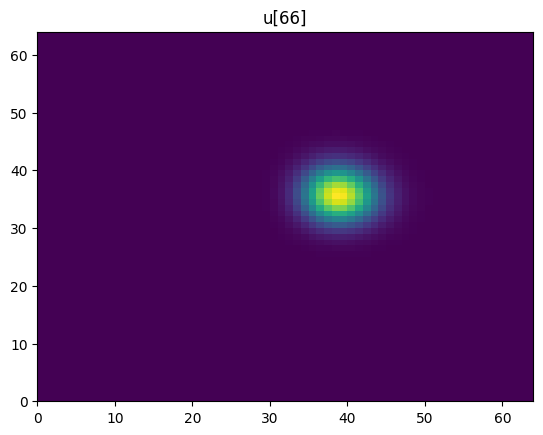

66


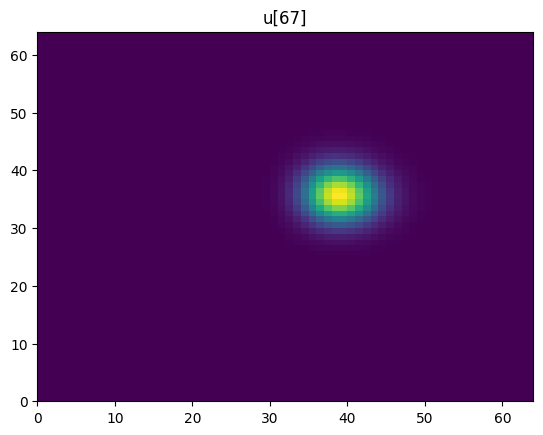

67


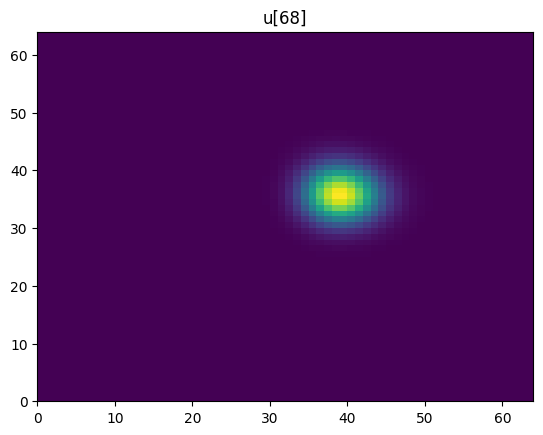

68


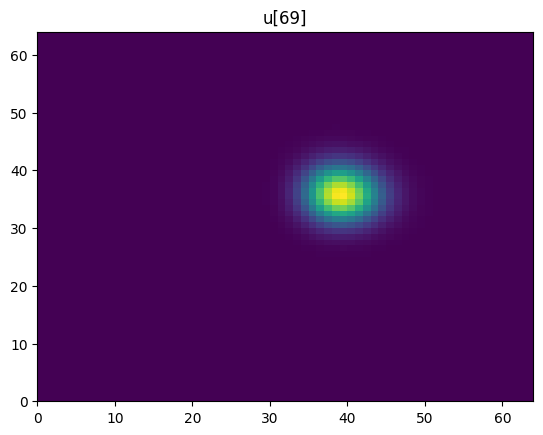

69


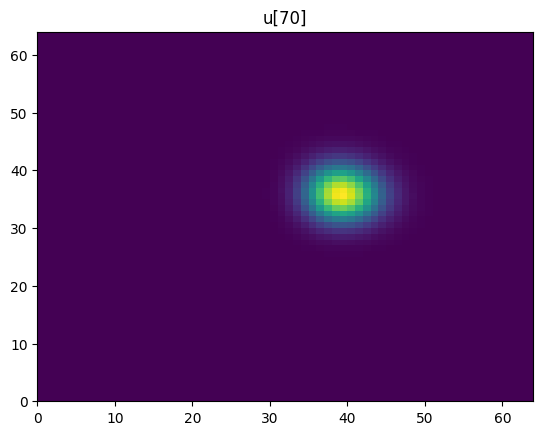

70


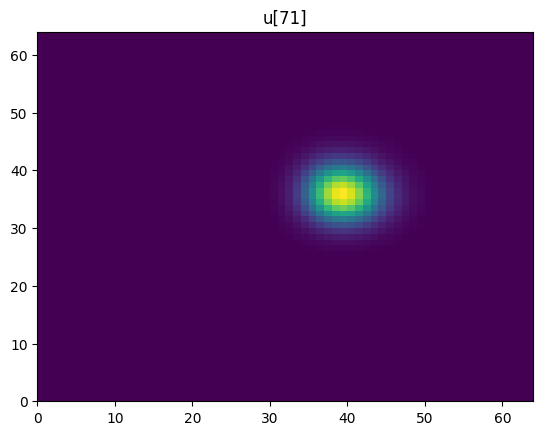

71


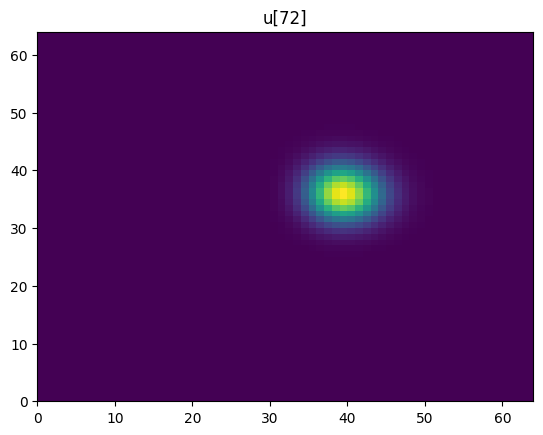

72


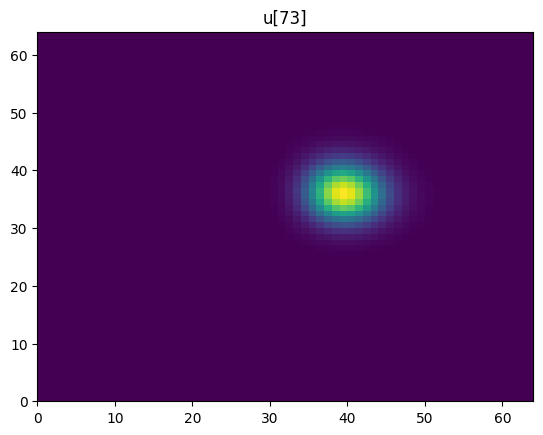

73


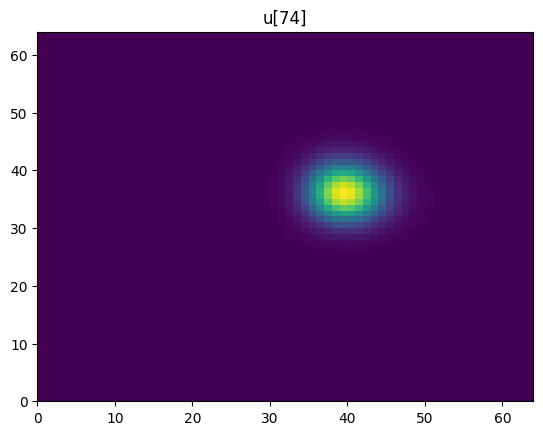

74


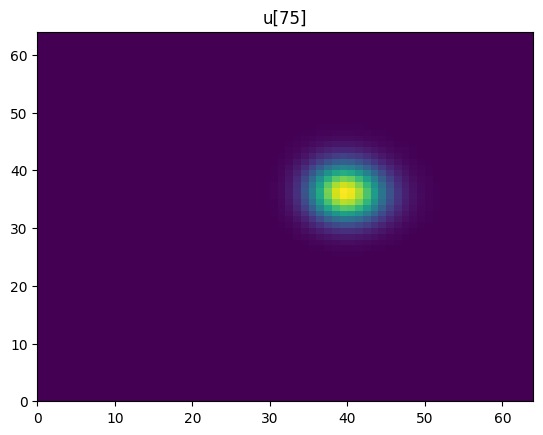

75


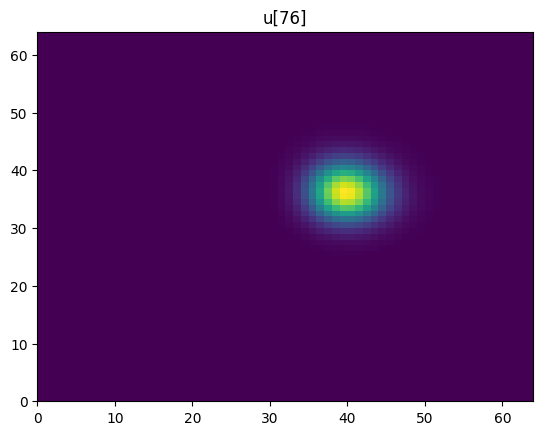

76


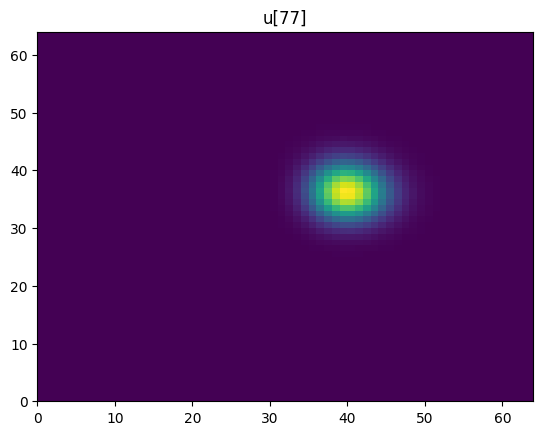

77


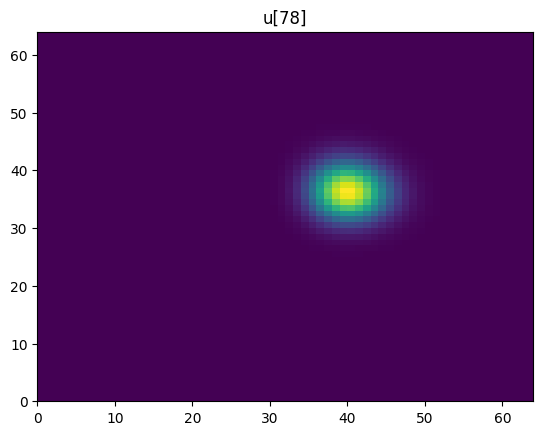

78


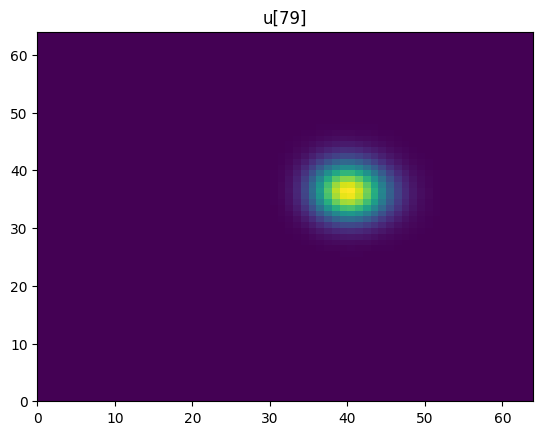

79


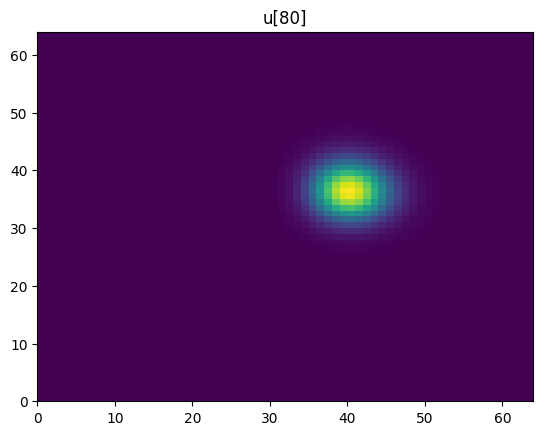

80


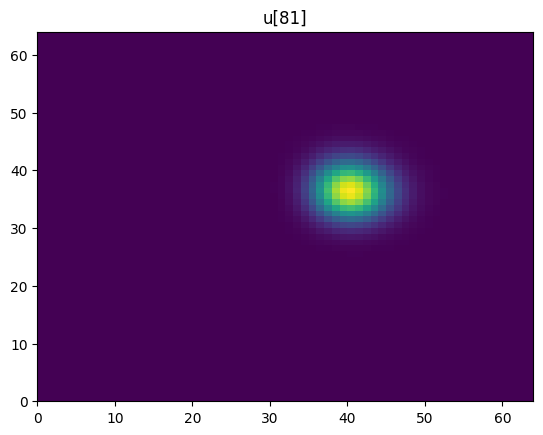

81


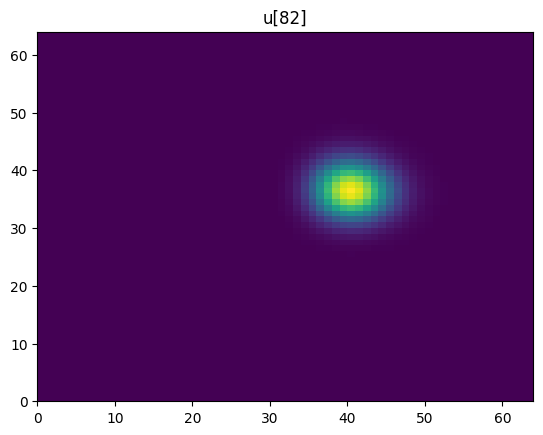

82


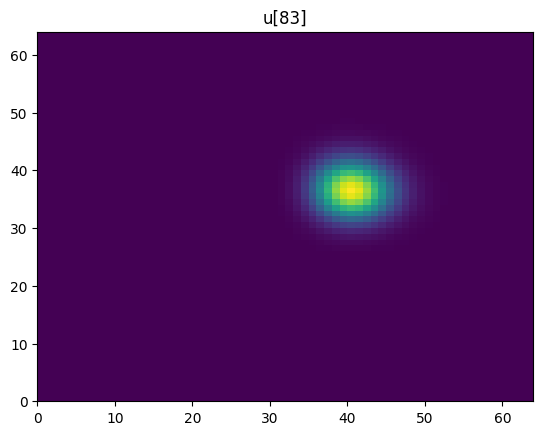

83


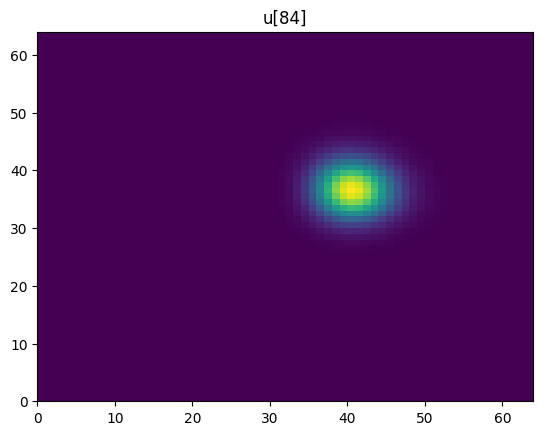

84


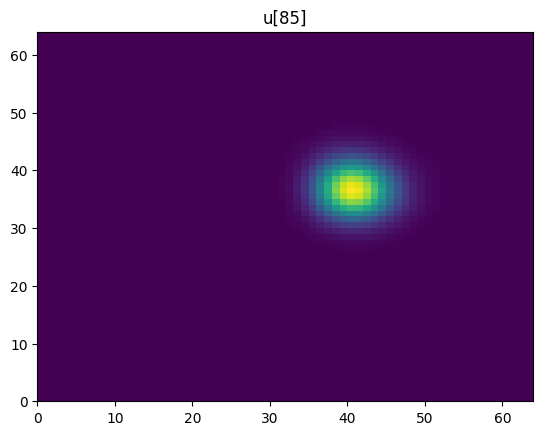

85


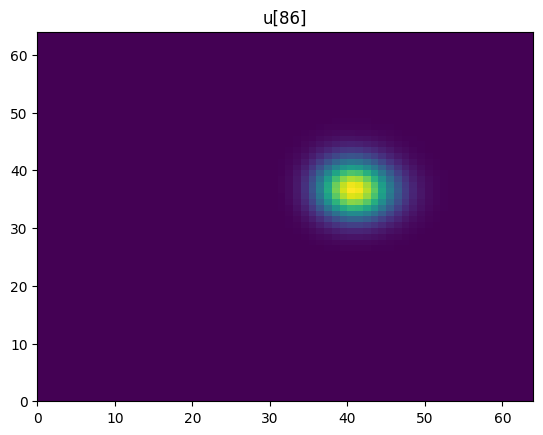

86


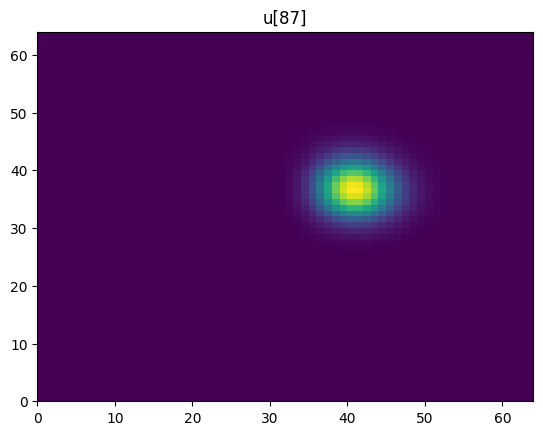

87


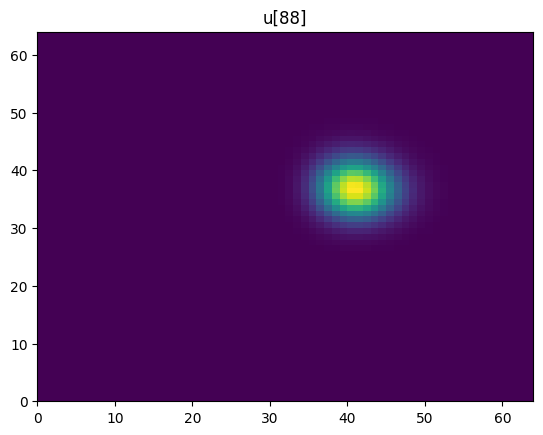

88


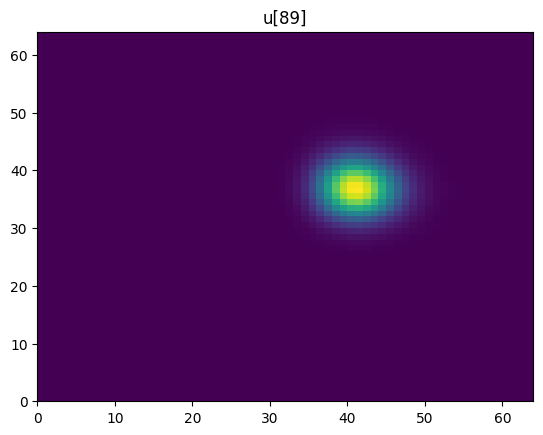

89


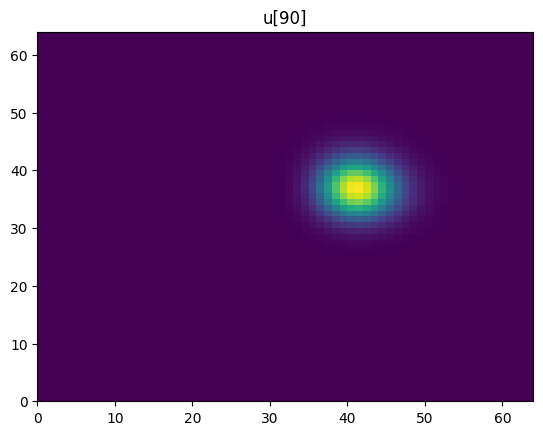

90


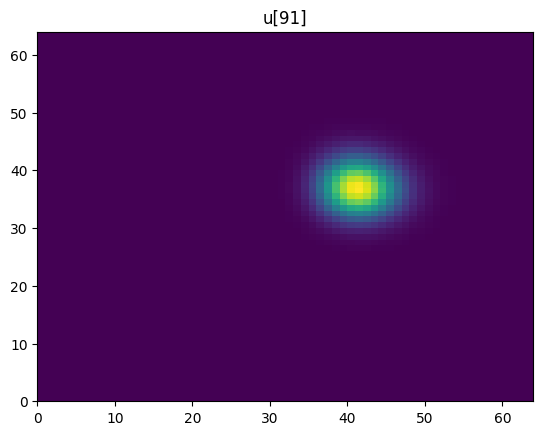

91


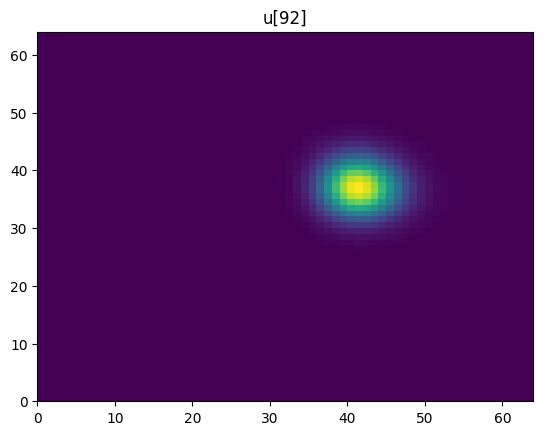

92


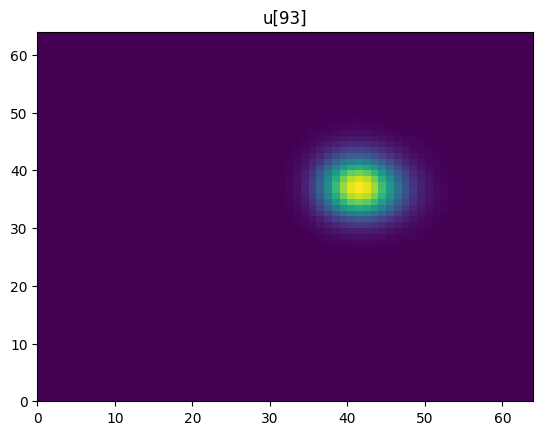

93


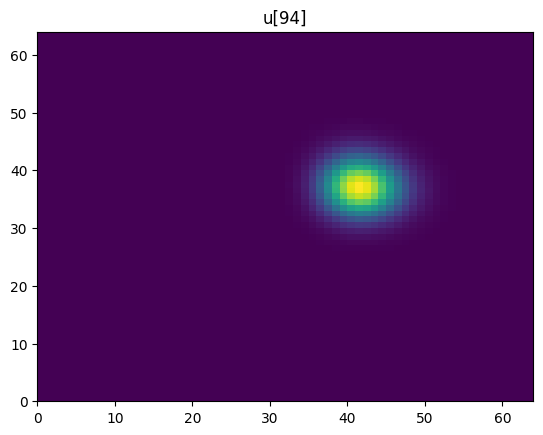

94


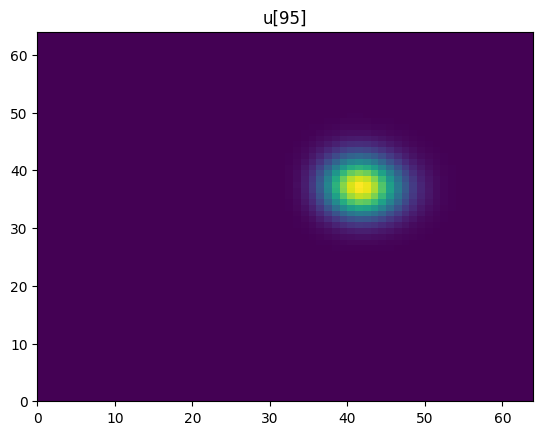

95


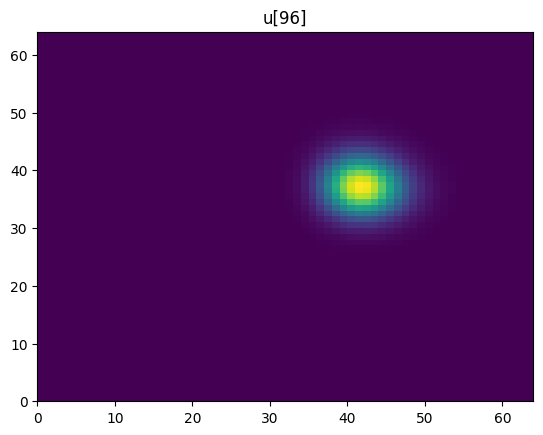

96


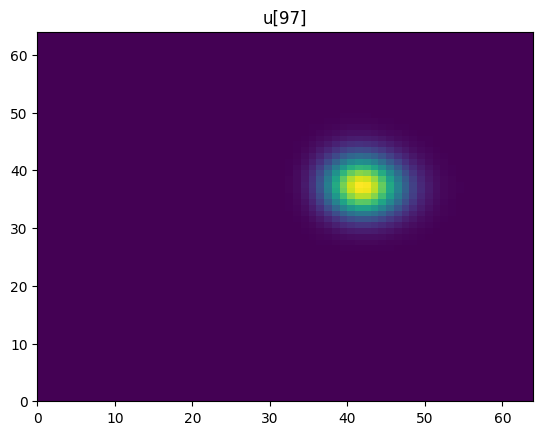

97


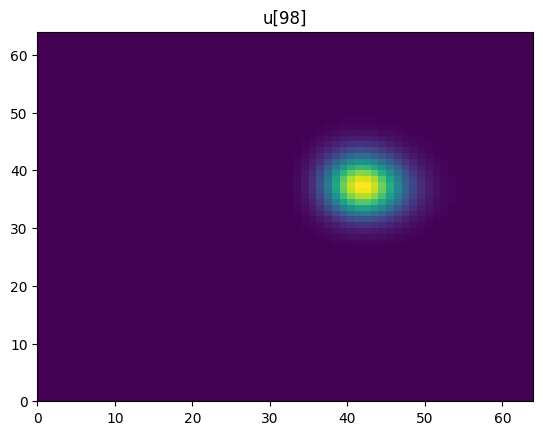

98


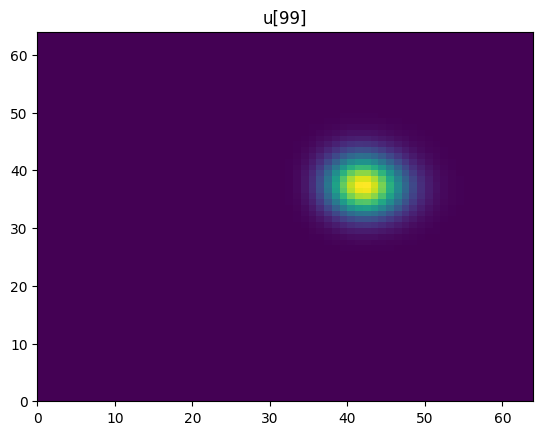

In [ ]:
import numpy as np
import scipy

N = 64
bounds = np.array([0, N])
L = bounds[1] - bounds[0]
dx = L / N
x = np.linspace(bounds[0], bounds[1], N, endpoint = False)
y = np.linspace(bounds[0], bounds[1], N, endpoint = False)
X, Y = np.meshgrid(x, y)

dt = 0.05

max_iter_time = 100

# Initialize solution: the grid of u(k, i, j)
u = np.zeros((max_iter_time, N, N))
u[0] = np.exp(- ((X - 32)**2 + (Y - 32)**2)/16)

# Set the initial condition
# u[0, N // 4 : 3 * N //4, N // 4 : 3 * N // 4] = 10

plt.pcolormesh(u[0])
plt.show()

v_x = 2
v_y = 1
d = 0.5 ## TODO: add diffusion coefficient

for k in range(max_iter_time - 1):
    print(k)
    grad_vx = np.gradient(u[k])[1] * v_x
    grad_vy = np.gradient(u[k])[0] * v_y
    # plt.pcolormesh(grad_vx)
    # plt.title("y gradient")
    # plt.show()
    # plt.pcolormesh(grad_vy)
    # plt.title("x gradient")
    # plt.show()

    op = -dt * (grad_vx + grad_vy) / dx
    lap_kernel = 1 / (dx ** 2) * np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    op += d * dt * scipy.signal.convolve2d(u[k], lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
    u[k + 1] = u[k] + op
    plt.pcolormesh(u[k + 1])
    plt.title(f"u[{k + 1}]")
    plt.show()

In [ ]:
#@title CNN
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# import jax
# from jax import numpy as jnp
import numpy as np
import tensorflow.keras as keras
import pandas as pd

initial.shape=(10, 32, 32, 1)


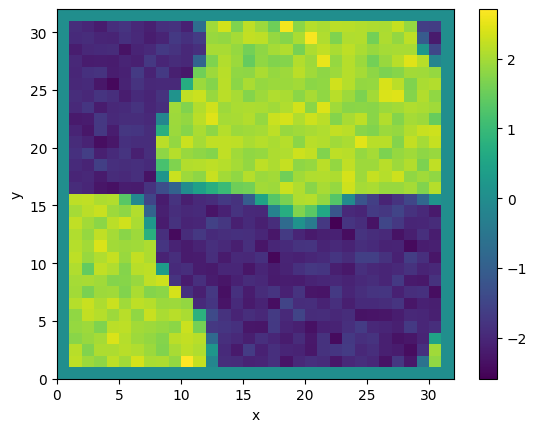

1: initial.shape=(10, 32, 32, 1)
2: initial.shape=(18, 32, 32, 1)
3: initial.shape=(28, 32, 32, 1)
4: initial.shape=(38, 32, 32, 1)
5: initial.shape=(48, 32, 32, 1)
6: initial.shape=(58, 32, 32, 1)
7: initial.shape=(68, 32, 32, 1)
8: initial.shape=(73, 32, 32, 1)
9: initial.shape=(83, 32, 32, 1)
10: initial.shape=(93, 32, 32, 1)
11: initial.shape=(103, 32, 32, 1)
12: initial.shape=(113, 32, 32, 1)
13: initial.shape=(123, 32, 32, 1)
14: initial.shape=(130, 32, 32, 1)
15: initial.shape=(134, 32, 32, 1)
16: initial.shape=(138, 32, 32, 1)
17: initial.shape=(148, 32, 32, 1)
18: initial.shape=(158, 32, 32, 1)
19: initial.shape=(168, 32, 32, 1)
20: initial.shape=(178, 32, 32, 1)
21: initial.shape=(188, 32, 32, 1)
22: initial.shape=(192, 32, 32, 1)
23: initial.shape=(192, 32, 32, 1)
initial.shape=(0, 32, 32, 1)
26: initial.shape=(0, 32, 32, 1)
27: initial.shape=(10, 32, 32, 1)
28: initial.shape=(20, 32, 32, 1)
29: initial.shape=(30, 32, 32, 1)
(202, 32, 32, 1)


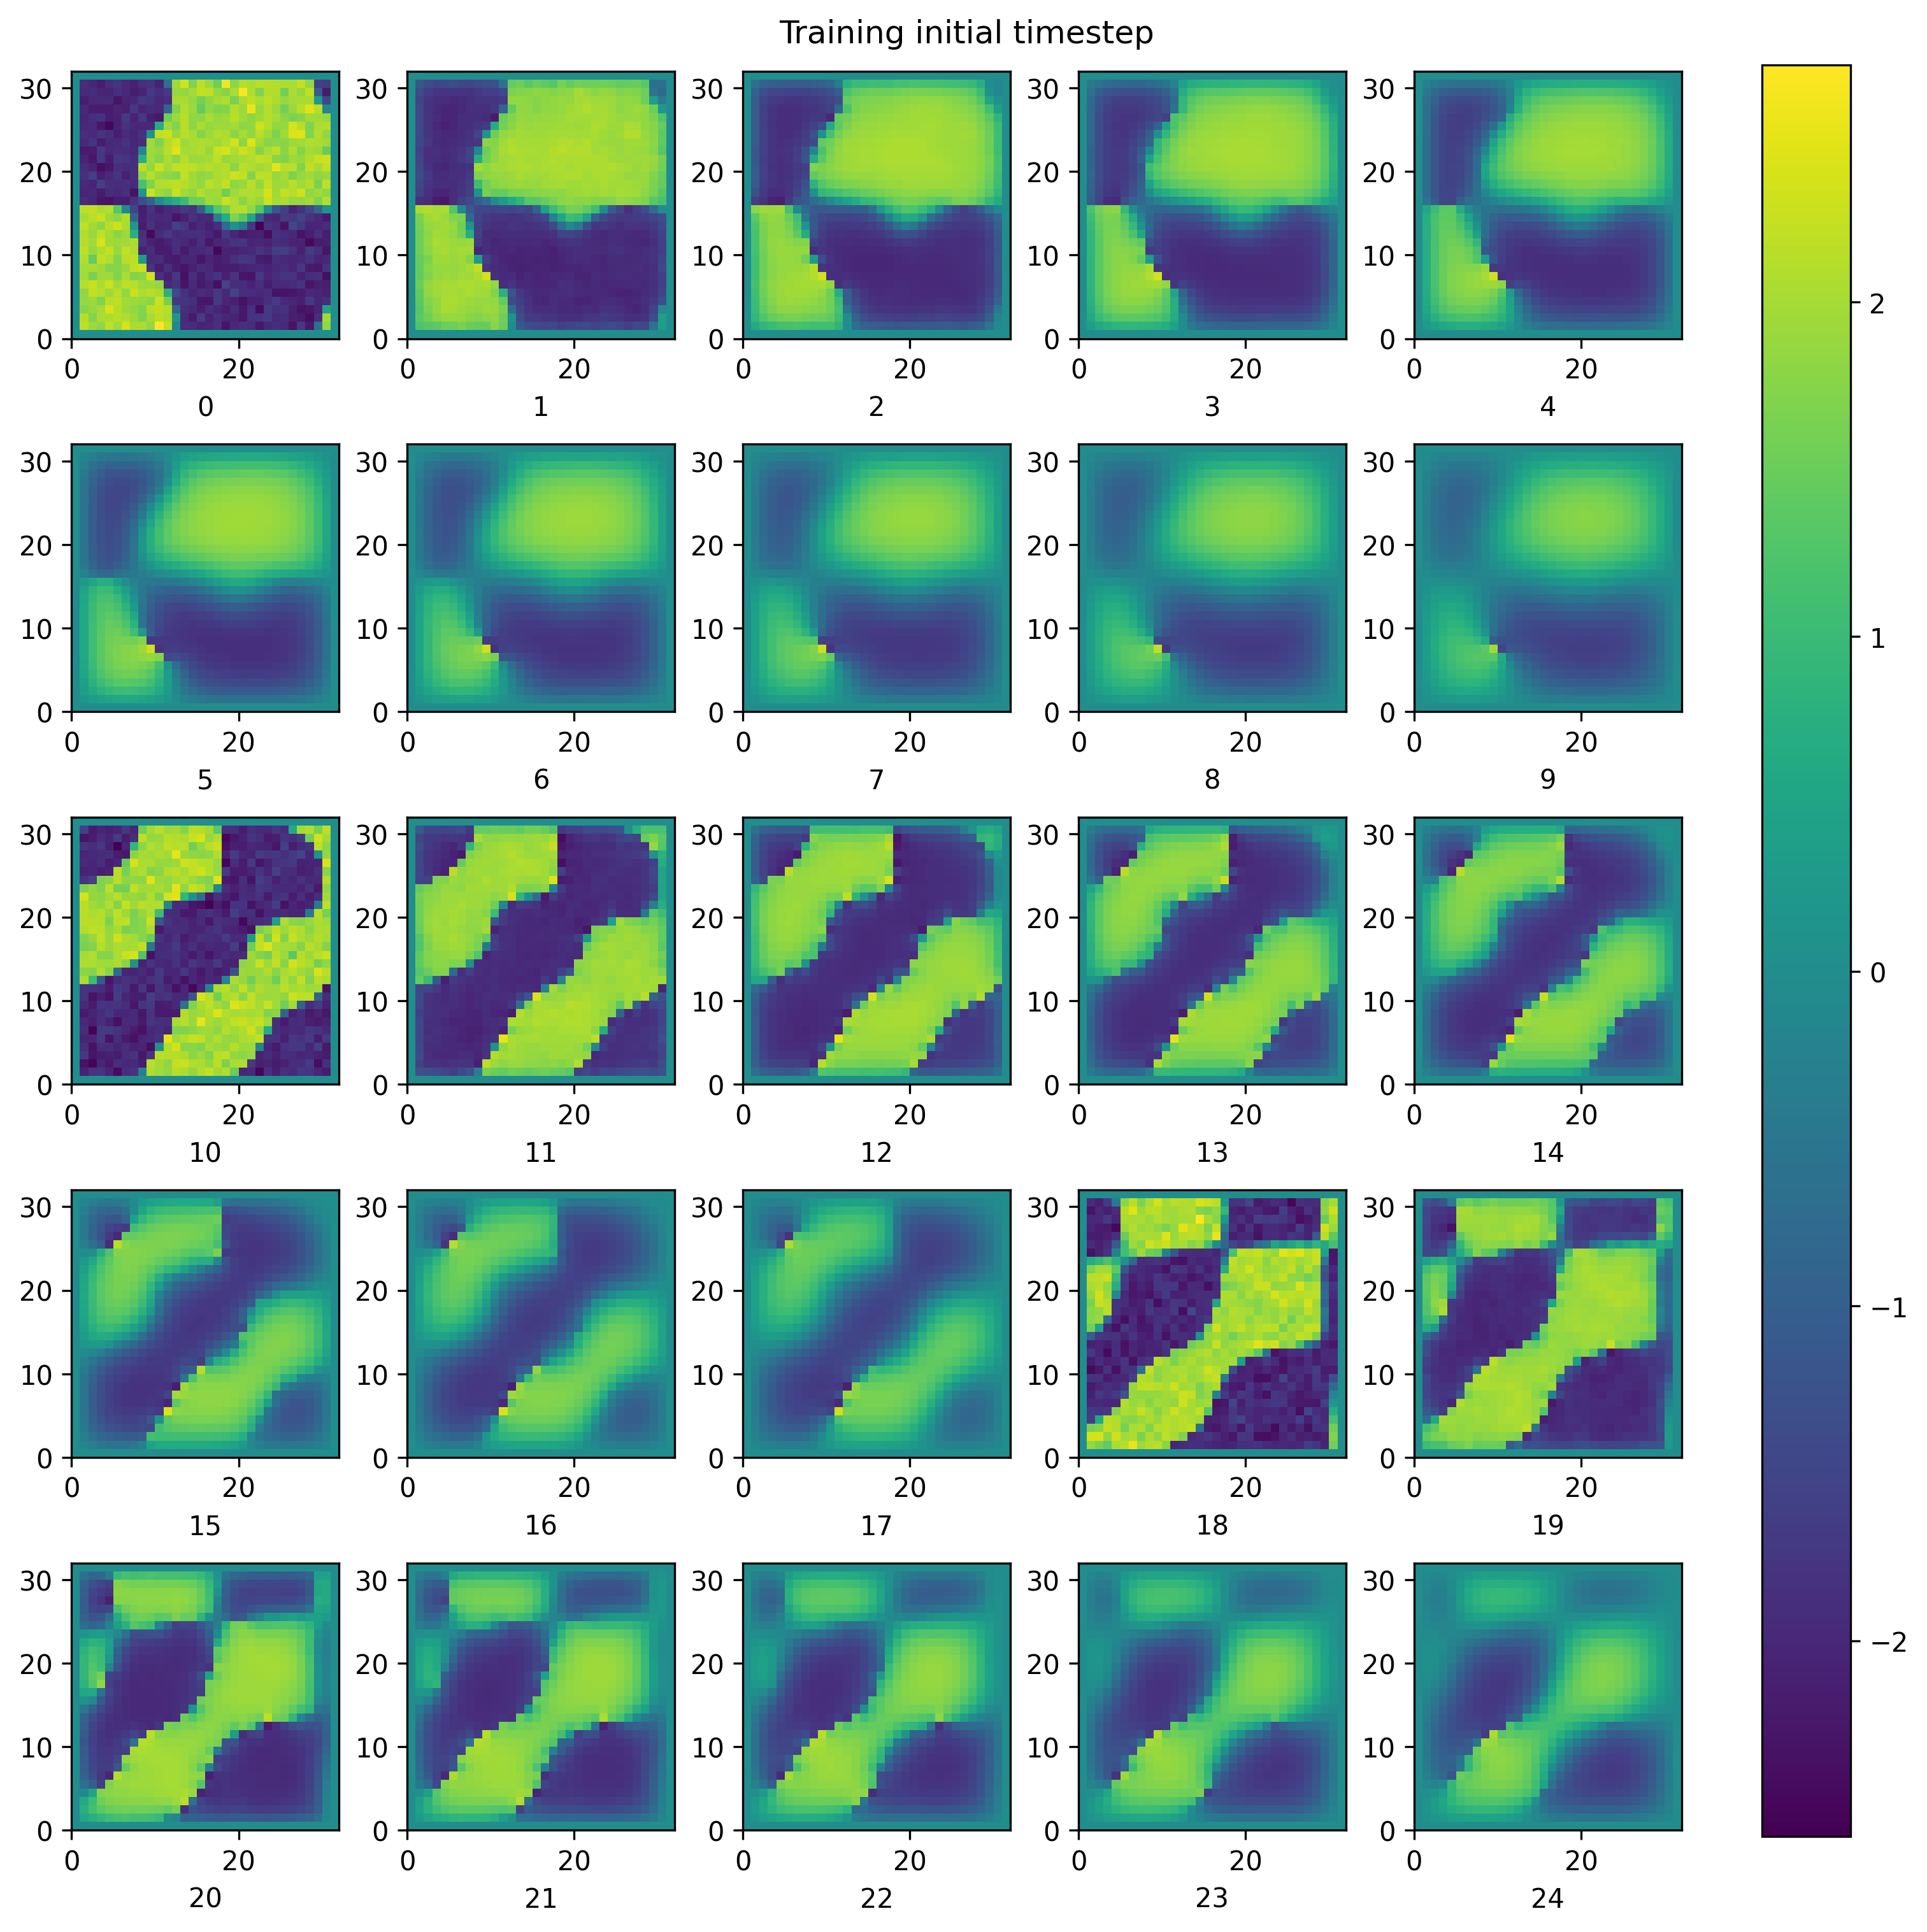

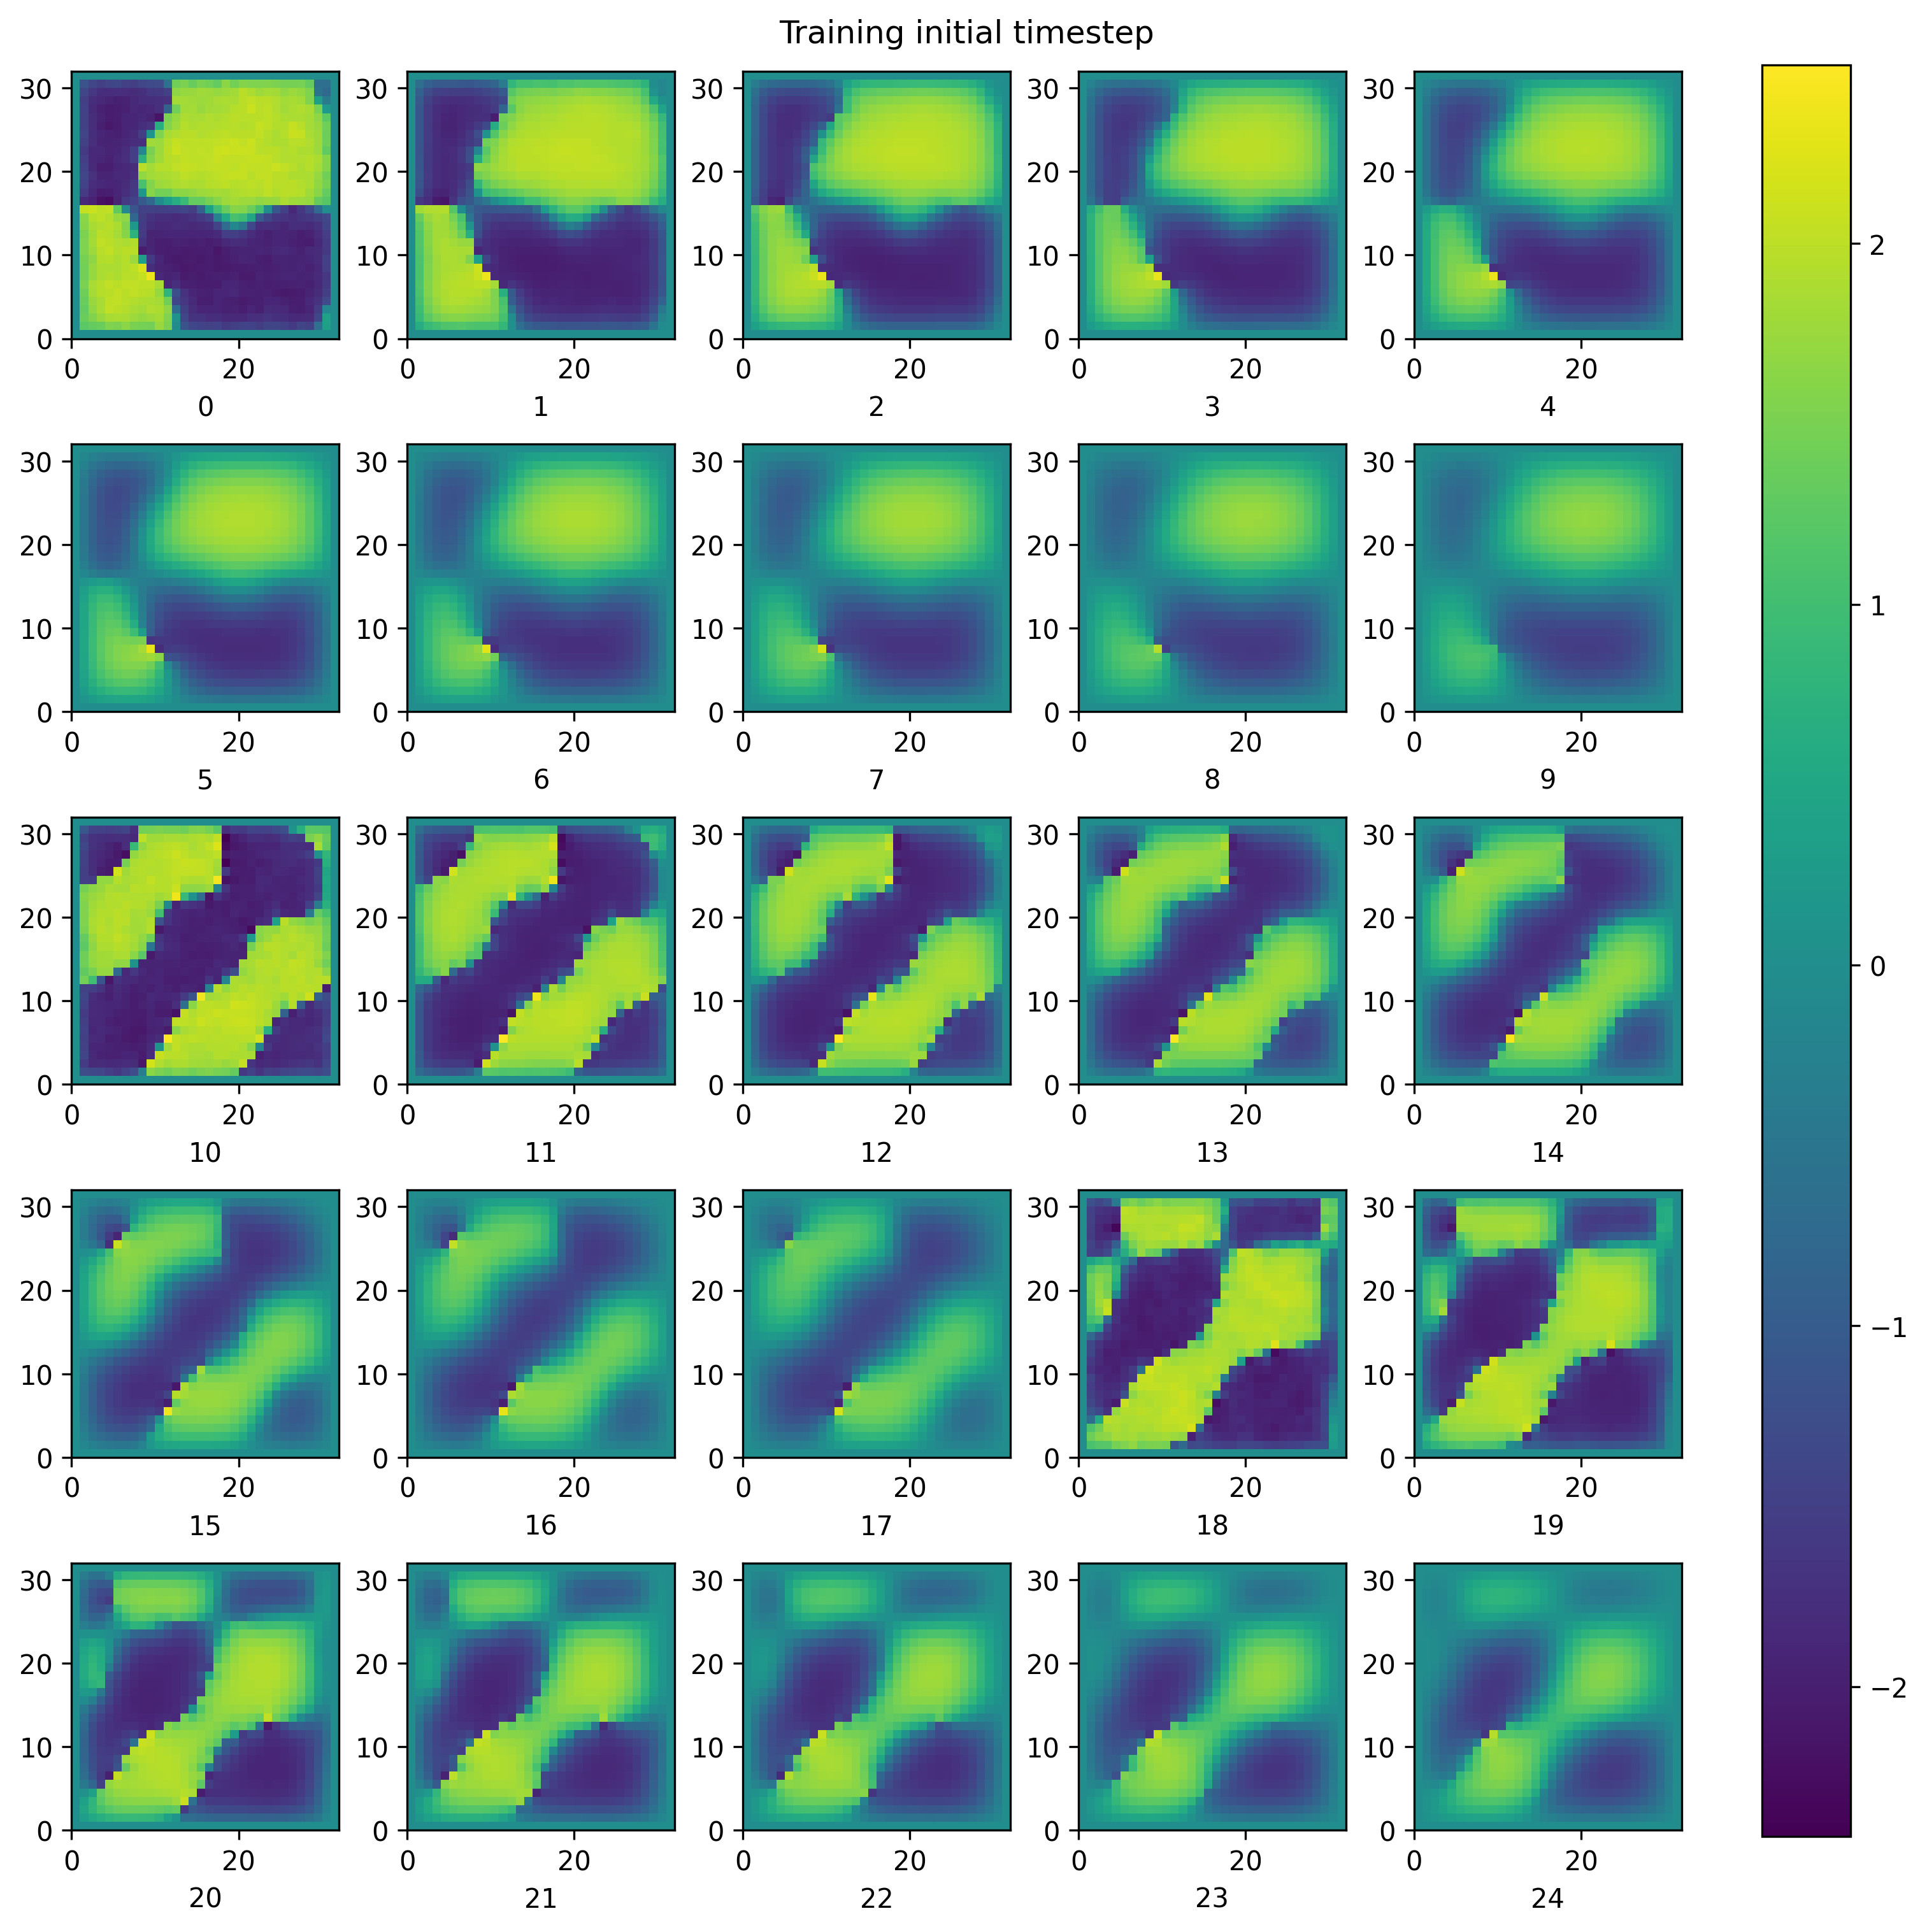

In [ ]:
from matplotlib.font_manager import dataclasses
## https://www.tensorflow.org/tutorials/images/cnn

folder = "/content/drive/MyDrive/superUROP/2023-11-29"
N = 32
def description(i = None):
    if i is None:
        return f"diffusion_test5_32x32_newton_0.04"
    else:
        return f"diffusion_test5_32x32_newton_{i}_0.04"

"""
Load training/testing data from numpy file

Parameters:
* n_t : number of timesteps to load for each initial condition
* (i_start, i_stop) : load data with initial condition seeds in this range
* show : if True, displays the data as a plot
"""
def load_data(n_t, i_start, i_stop, description, show = False):
    n_t = 10 # train on each data from an train_initial condition, up to the first n_t timesteps

    # load first data i
    i = i_start
    data = np.load(f"{folder}/{description(i)}.npy")
    max_n_t = data.shape[0]
    initial = np.expand_dims(data[:min(n_t, max_n_t - 1), :, :], axis = -1)
    next = np.expand_dims(data[1 : min(n_t, max_n_t - 1) + 1, :, :], axis = -1)
    print(f"{initial.shape=}")
    if initial.shape[0] > 0:
        plot_data(initial[0, :, :, 0], show = show)
    i += 1

    while i < i_stop:
        data = np.load(f"{folder}/{description(i)}.npy")
        max_n_t = data.shape[0]
        initial_i = np.expand_dims(data[: min(n_t, max_n_t - 1), :, :], axis = -1)
        print(f"{i}: {initial.shape=}")
        next_i = np.expand_dims(data[1 : min(n_t, max_n_t - 1) + 1, :, :], axis = -1)
        initial = np.concatenate((initial, initial_i), axis = 0)
        next = np.concatenate((next, next_i), axis = 0)
        i += 1
    predict = initial - next
    return initial, predict, next

"""
Parameters:
* n_t : number of timesteps to load for each initial condition
* n_plot : number of initial conditions to plot
"""
def plot_first_j(data, n_t, n_plot = None, shape = (3, 3), title = "", dpi = 300, save = False):
    # N = data.shape[1]
    if n_plot is None:
        n_plot = data.shape[0] // n_t
    for j in range(n_plot): # for each initial condition
        print(f"plotting {j=}")
        fig, axs = plt.subplots(shape[0], shape[1], figsize=(2 * shape[1], 2 * shape[0]), dpi = dpi, constrained_layout=True)
        fig.suptitle(title)
        vmin = np.min(data[n_t * j : n_t * (j + 1), :, :, :])
        vmax = np.max(data[n_t * j : n_t * (j + 1), :, :, :])
        for i in range(shape[0]):
            for k in range(shape[1]):
                # axs[0].
                # ax = axs[0].subplot(shape[0], shape[1], i+1)
                # plt.xticks([])
                # plt.yticks([])
                # plt.grid(False)
                m = axs[i, k].pcolormesh(data[n_t * j + i * shape[1] + k, :, :, 0], vmin = vmin, vmax = vmax)
                # plt.colorbar(m)
                # The CIFAR labels happen to be arrays,
                # which is why you need the extra index
                axs[i, k].set_xlabel(i * shape[1] + k)
                axs[i, k].set_aspect('equal')
        fig.colorbar(m, ax=axs.ravel().tolist())
        if save:
            plt.savefig(f"{folder}/{description()}_plot{shape[0]}x{shape[1]}_{j}.png")
        plt.show()

def plot_first_25(data, title = "", dpi = 300, save = False, vmax = None, vmin = None):
    shape = (5, 5)
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(2 * shape[1], 2 * shape[0]), dpi = dpi, constrained_layout=True)
    fig.suptitle(title)
    if vmin is None:
        vmin = np.min(data[:shape[0] * shape[1], :, :, :])
    if vmax is None:
        vmax = np.max(data[:shape[0] * shape[1], :, :, :])
    for i in range(shape[0]):
        for k in range(shape[1]):
            m = axs[i, k].pcolormesh(data[i * shape[1] + k, :, :, 0], vmin = vmin, vmax = vmax)
            axs[i, k].set_xlabel(i * shape[1] + k)
            axs[i, k].set_aspect('equal')
    fig.colorbar(m, ax=axs.ravel().tolist())
    if save:
        plt.savefig(f"{folder}/{description()}_plot{shape[0]}x{shape[1]}.png")
    plt.show()


def load_train_test_data():
    train_range = range(0, 24)
    test_range = range(25, 30)
    n_t = 10
    train_initial, train_predict, train_next = load_data(n_t = 10, i_start = train_range.start, i_stop = train_range.stop, description = description, show = True)
    test_initial, test_predict, test_next = load_data(n_t = 10, i_start = test_range.start, i_stop = test_range.stop, description = description, show = True)
    print(train_initial.shape)
    plot_first_25(data = train_initial, title = "Training initial timestep", save = False)
    plot_first_25(data = train_next, title = "Training initial timestep", save = False)
    # plot_first(data = train_next, n_t = 10, n_plot = 5, shape = [2, 5], title = "Training next timestep", save = False)
    # plot_first(data = train_predict, n_t = 10, n_plot = 5, shape = [2, 5], title = "Training difference", save = False)
    return train_initial, train_predict, train_next, test_initial, test_predict, test_next
train_initial, train_predict, train_next, test_initial, test_predict, test_next = load_train_test_data()

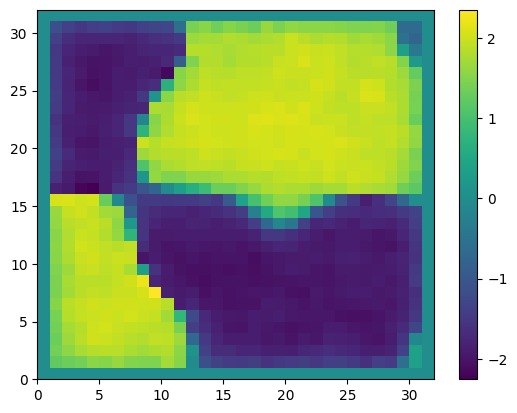

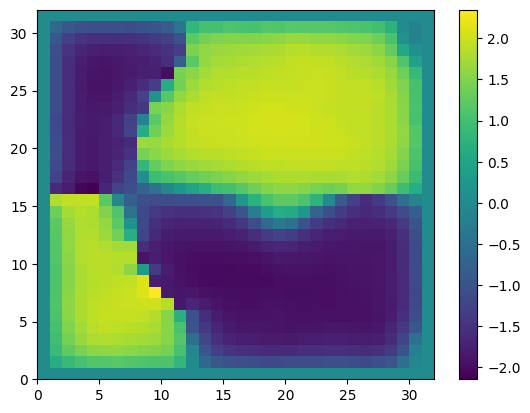

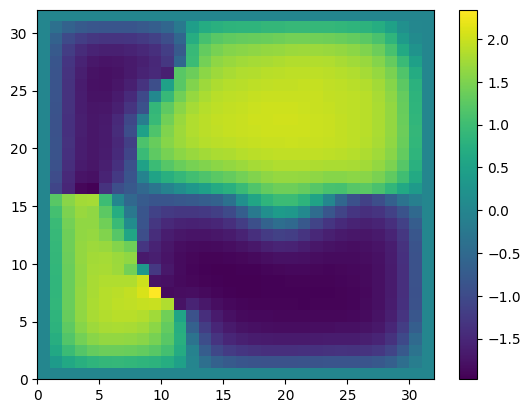

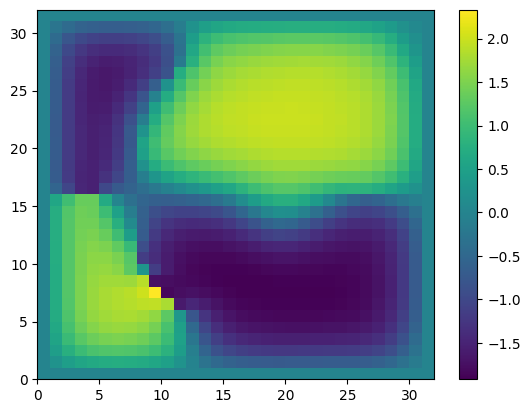

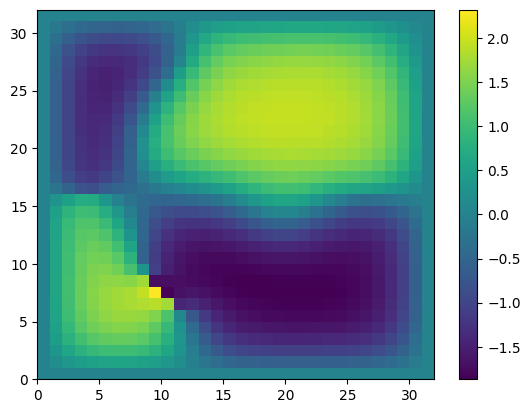

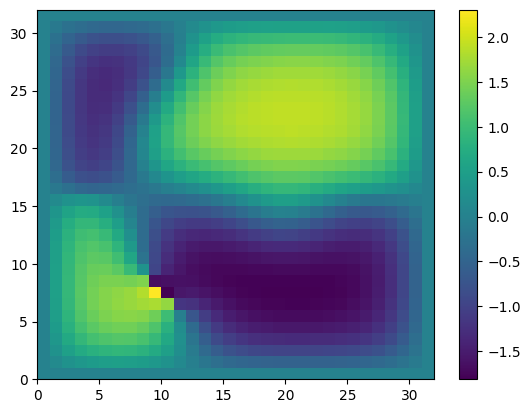

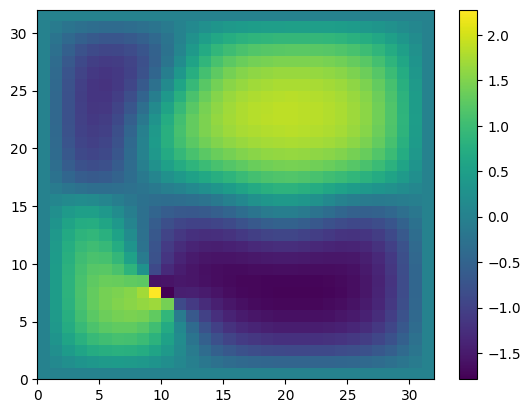

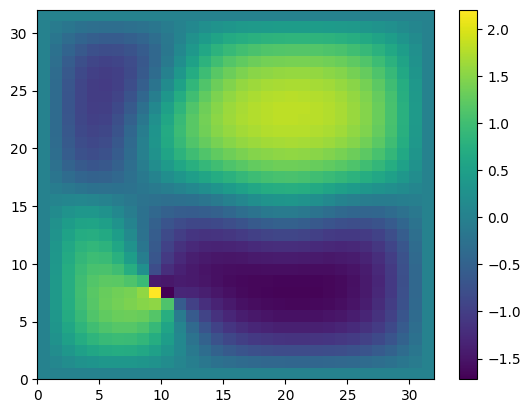

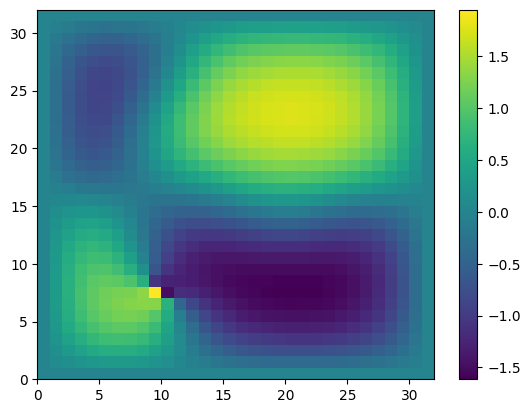

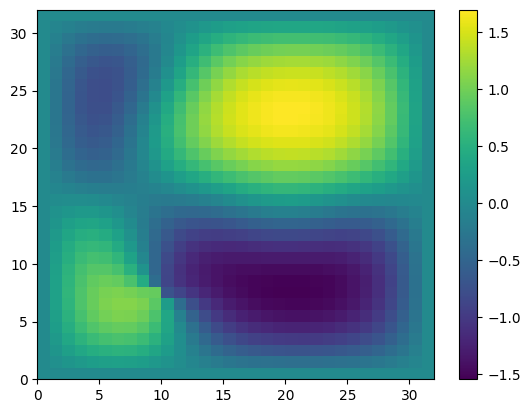

average mae: 0.957265239393357
median mae: 0.914229691028595


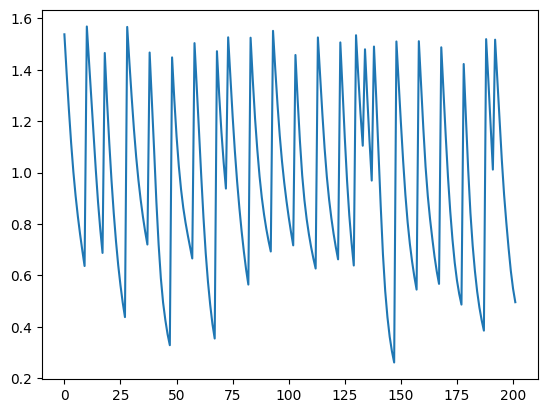

In [ ]:
def plot_maes(train_initial, test_initial):
    maes = np.array([])
    for i in range(train_initial.shape[0]):
        diff = train_initial[i, :, :, :] - train_predict[i, :, :, :]
        mae = np.abs(diff).mean()
        maes = np.append(maes, mae)
        if i < 10:
            m = plt.pcolormesh(np.squeeze(diff))
            # m = plt.pcolormesh(train_initial[i, :, :, 0])
            plt.colorbar(m)
            plt.show()
            # m = plt.pcolormesh(train_predict[i + 1, :, :, 0] - train_initial[i, :, :, 0])
            # plt.colorbar(m)
            # plt.show()
    plt.plot(maes)
    print(f"average mae: {np.mean(maes)}")
    print(f"median mae: {np.median(maes)}")
plot_maes(train_initial, test_initial)

In [ ]:
from re import X
# https://stackoverflow.com/questions/42384602/implementing-skip-connections-in-keras
import tensorflow as tf
from tensorflow.keras import layers, models

def skip_net():
    input_net = layers.Input(shape = (N, N, 1))
    conv1 = layers.Convolution2D(32, (3, 3), activation = 'relu', padding = "same")(input_net)
    conv2 = layers.Convolution2D(64, (3, 3), activation = 'relu', padding = "same")(conv1)
    conv3 = layers.Convolution2D(32, (3, 3), activation = 'relu', padding = "same")(conv2)
    conv3 = layers.Concatenate()([conv2, conv3])
    conv4 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(conv3)
    conv4 = layers.Concatenate()([conv1, conv4])
    output_net = layers.Convolution2D(1, (3, 3), activation = 'linear', padding = "same")(conv4)
    model = models.Model(inputs = input_net, outputs = output_net)
    tf.keras.utils.plot_model(model, f"{folder}/skip_net_graph.png")
    print("make sure the output size is correct")
    return model

def skip_net_small(N = 32):
    input_net = layers.Input(shape = (N, N, 1))
    conv1 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(input_net)
    conv2 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(conv1)
    conv3 = layers.Convolution2D(16, (3, 3), activation = 'relu', padding = "same")(conv2)
    conv4 = layers.Concatenate()([conv1, conv3])
    conv5 = layers.Concatenate()([input_net, conv4])
    conv5 = layers.Convolution2D(1, (3, 3), activation = 'linear', padding = "same")(conv5)
    output_net = layers.Add()([input_net, conv5])
    model = models.Model(inputs = input_net, outputs = conv5)
    tf.keras.utils.plot_model(model, f"{folder}/skip_net_graph.png")
    print("plotted")
    return model

def create_model():
    model = skip_net_small()

    lr = 0.001
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='mean_squared_error',
                metrics=['mae'])
    print(f"Learning rate: {lr}")

    # plot_data(train_initial[2, :, :, 0], show = True)
    # plot_data(train_predict[2, :, :, 0], show = True)

    hist_csv_file = f'{folder}/{description()}_history.csv'
    with open(hist_csv_file, mode='w') as f:
        pd.DataFrame().to_csv(f)
    return model, hist_csv_file

# model, hist_csv_file = create_model()

In [ ]:
def train_model(lr):
    keras.backend.set_value(model.optimizer.learning_rate, lr)
    history = model.fit(train_initial, train_next, epochs=1, batch_size = 100)
    model.save(f"{folder}/{description()}_model")
    # return history.history['mae']
    return history.history

def plot_history_mae(history): #history):
    plt.plot(history['mae'], label='mean absolute error')
    # plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.yscale('log')
    # plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.savefig(f"{folder}/{description}_loss")
    plt.show()
    train_loss, train_acc = model.evaluate(train_initial, train_next, verbose=2)
    test_loss, test_acc = model.evaluate(test_initial, test_next, verbose=2)
    print(f"{train_loss=}, {train_acc=}, {test_loss=}, {test_acc=}")

run = False
if run:
        # Print initial loss/accuracy
        starting_loss, starting_acc = model.evaluate(train_initial, train_next, verbose=2)
        print(f"{starting_loss=}, {starting_acc=}")

        ## Read history dataframe from file; will append new history data if existing already
        hist_df = pd.read_csv(hist_csv_file)
        if hist_df.empty:
            history = {}
        else:
            history = hist_df.to_dict('list')
            print(history)

        lr = 0.0005
        for i in range(100):
            history_i = train_model(lr = lr)
            for metric in history_i:
                if metric in history:
                    history[metric] = np.append(history[metric], history_i[metric])
                else:
                    history[metric] = history_i[metric]
            # print(history)
            with open(hist_csv_file, mode='w') as f:
                pd.DataFrame.from_dict(history).to_csv(f, index = False)
            # np.save(file = hist_csv_file, arr = history_maes)
        # print(history)

        plot_history_mae(history)


In [ ]:
hist_df = pd.read_csv(hist_csv_file)
print(hist_df)
history = hist_df.to_dict('list')
print(history)

NameError: name 'hist_csv_file' is not defined

In [ ]:
#@title Load Model

#@title CNN
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# import jax
# from jax import numpy as jnp
import numpy as np
import tensorflow.keras as keras

folder = "/content/drive/MyDrive/superUROP/2023-11-29"
def description(i = None):
    if i is None:
        return f"diffusion_test5_32x32_newton_0.04"
    else:
        return f"diffusion_test5_32x32_newton_{i}_0.04"

model = keras.models.load_model(f"{folder}/{description()}_model")
N = 32

# ## Plot first 25 inputs
# def plot_results(data, title = "", n = 3, vmax = None, vmin = None):
#     plt.figure(figsize=(10,10), dpi = 200)
#     plt.title("HELLO")
#     if vmax is None:
#         vmax = np.max(data[:n**2])
#     if vmin is None:
#         vmin = np.min(data[:n**2])
#     for i in range(n**2):
#         plt.subplot(n, n, i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         m = plt.pcolormesh(data[i, :, :, 0], vmin = vmin, vmax = vmax)
#         plt.colorbar(m)
#         plt.title(title)
#         # The CIFAR labels happen to be arrays,
#         # which is why you need the extra index
#         plt.xlabel(i)
#     plt.savefig(f"{folder}/{description()}_{title}.png")
#     plt.show()

# train_initial, train_predict, train_next, test_initial, test_predict, test_next = load_train_test_data()


train_loss, train_acc = model.evaluate(train_initial, train_next, verbose=2)
def plot_test_results(model, test_initial, test_next):
    test_loss, test_acc = model.evaluate(test_initial, test_next, verbose=2)
    predicted = model.predict(test_initial)
    vmax = np.max([predicted, test_next])
    vmin = np.min([predicted, test_next])

    plot_first_25(predicted, title = "Predicted", vmax = vmax, vmin = vmin)
    plot_first_25(test_next, title = "Target", vmax = vmax, vmin = vmin)
    plot_first_25(predicted - test_next, title = "Difference")

plot_test_results(model, test_initial, test_next)
# predicted = model.predict(initial)
# plot_results(predicted, title = "Predicted")
# plot_results(predict, title = "Actual")
# plot_results(predicted - predict, title = "Difference")

In [ ]:
## Test "out of distribution" data

folder = "/content/drive/MyDrive/superUROP/2023-11-29"
N = 32
def description4(i = None):
    if i is None:
        return f"diffusion_test4_32x32_newton_0.04"
    else:
        return f"diffusion_test4_32x32_newton_{i}_0.04"

test4_range = range(0, 7)
n_t = 10
test4_initial, test4_predict, test4_next = load_data(n_t = n_t, i_start = test4_range.start, i_stop = test4_range.stop, description = description4, show = True)
# plot_first_25(data = test4_initial, title = "Training initial timestep", save = False)
# plot_first_25(data = test4_next, title = "Training next timestep", save = False)

plot_test_results(model, test4_initial, test4_next)


In [ ]:
import time

dt = 0.04
def compare_time_iters(ic_test = 5):
    cnn_times = []
    regular_times = []
    cnn_iters = []
    regular_iters = []

    seeds = np.arange(start = 0, stop = 10)
    max_iter_time = 5
    newton_max_iter = 15
    ic_test = 4
    N = 32
    for i in seeds:
        print(i)
        start = time.time()
        u, anim, n_iters = newton_solver(seed = i, save_mp4 = True, method = "newton", initializer = lambda x: model.predict(x), dt = dt, ic_test = ic_test, max_iter_time = max_iter_time, newton_max_iter = newton_max_iter, N = N)
        end = time.time()
        cnn_times.append(end - start)
        print(f"{n_iters=}")
        cnn_iters.append(n_iters)
        print(f"{cnn_iters=}")

        start = time.time()
        u, anim, n_iters = newton_solver(seed = i, save_mp4 = True, method = "newton", dt = dt, ic_test = ic_test, max_iter_time = max_iter_time, newton_max_iter = newton_max_iter, N = N)
        end = time.time()
        regular_times.append(end - start)
        regular_iters.append(n_iters)

        print(f"{regular_iters=}")
        print(f"{cnn_iters=}")
        print(f"{regular_times=}")
        print(f"{cnn_times=}")
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_regular_iters", arr = regular_iters)
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_cnn_iters", arr = cnn_iters)
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_regular_times", arr = regular_times)
        np.save(file = f"{folder}/{description()}_model_ictest{ic_test}_N{N}_cnn_times", arr = cnn_times)
        ## Plot
        plt.figure()
        plt.scatter(seeds[:len(regular_times)], regular_times, label = "regular times", color = 'red', marker = 'x')
        plt.scatter(seeds[:len(cnn_times)], cnn_times, label = "cnn times", color = 'blue', marker = 'x')
        plt.legend()
        plt.ylim(bottom = 0)
        plt.title("Time Comparison (seconds)")
        plt.show()

        plt.scatter(seeds[:len(regular_iters)], [np.average(it_t[:-1]) for it_t in regular_iters], label = "regular iterations", color = 'red', marker='x')
        plt.scatter(seeds[:len(cnn_iters)], [np.average(it_t[:-1]) for it_t in cnn_iters], label = "cnn iterations", color = 'blue', marker='x')
        plt.legend()
        plt.ylim(bottom = 0)
        plt.title("Average number of Iterations Comparison")
        plt.show()

    # ## Plot
    # plt.figure()
    # plt.scatter(seeds[:len(regular_times)], regular_times, label = "regular times", color = 'red', marker = 'x')
    # plt.scatter(seeds[:len(cnn_times)], cnn_times, label = "cnn times", color = 'blue', marker = 'x')
    # plt.legend()
    # plt.ylim(bottom = 0)
    # plt.title("Time Comparison (seconds)")
    # plt.show()

    # plt.scatter(seeds[:len(regular_iters)], [np.average(it_t[:-1]) for it_t in regular_iters], label = "regular iterations", color = 'red', marker='x')
    # plt.scatter(seeds[:len(cnn_iters)], [np.average(it_t[:-1]) for it_t in cnn_iters], label = "cnn iterations", color = 'blue', marker='x')
    # plt.legend()
    # plt.ylim(bottom = 0)
    # plt.title("Average number of Iterations Comparison")
    # return cnn_times, regular_times, cnn_iters, regular_iters, seeds

cnn_times, regular_times, cnn_iters, regular_iters, seeds = compare_time_iters()

In [ ]:
seeds = np.arange(start = 24, stop = 34)
regular_iters=[np.array([25.]), np.array([25.]), np.array([6., 6., 6., 6., 5., 5., 4., 4., 3., 3.]), np.array([ 5.,  6.,  6., 12.,  7.,  5.,  4.,  4.,  5.,  5.]), np.array([6., 6., 6., 6., 5., 5., 4., 4., 3., 3.]), np.array([6., 7., 6., 6., 6., 6., 5., 4., 3., 3.]), np.array([ 9.,  8., 18.,  7.,  6.,  7., 25.]), np.array([7., 5., 6., 6., 6., 5., 5., 4., 5., 6.]), np.array([ 6.,  7.,  6., 25.]), np.array([ 7., 25.])]
cnn_iters=[np.array([6., 6., 6., 5., 6., 6., 5., 3., 3., 3.]), np.array([6., 4., 5., 5., 6., 6., 4., 3., 3., 3.]), np.array([6., 5., 6., 5., 4., 4., 3., 3., 3., 3.]), np.array([ 5.,  5.,  6., 12.,  5.,  4.,  4.,  4.,  4.,  7.]), np.array([5., 5., 5., 5., 5., 4., 3., 3., 3., 3.]), np.array([4., 6., 5., 5., 6., 6., 4., 3., 3., 3.]), np.array([6., 6., 6., 6., 6., 8., 6., 7., 6., 4.]), np.array([5., 5., 6., 6., 5., 5., 4., 4., 4., 5.]), np.array([6., 6., 5., 6., 6., 6., 6., 7., 4., 3.]), np.array([6., 5., 5., 6., 5., 5., 5., 4., 7., 5.])]
regular_times=[41.068368673324585, 43.73337006568909, 92.15044736862183, 111.36302208900452, 93.6173186302185, 103.7004086971283, 149.43357825279236, 109.86091566085815, 82.07162308692932, 59.671379804611206]
cnn_times=[102.0141053199768, 95.23440480232239, 91.83798122406006, 115.2849760055542, 91.77917790412903, 99.30102181434631, 128.84389281272888, 112.48367381095886, 122.64945554733276, 120.42994666099548]

plt.figure()
plt.scatter(seeds[:len(regular_times)], [regular_times[i] / regular_iters[i].shape[0] for i in range(len(regular_iters))], label = "regular times", color = 'red', marker = 'x')
plt.scatter(seeds[:len(cnn_times)], [cnn_times[i] / cnn_iters[i].shape[0] for i in range(len(cnn_iters))], label = "cnn times", color = 'blue', marker = 'x')

# plt.scatter(seeds[:len(cnn_times)], cnn_times, label = "cnn times", color = 'blue', marker = 'x')
plt.legend()
plt.ylim(bottom = 0)
plt.ylabel("Initial Seed")
plt.title("Time per iteration Comparison (seconds)")
plt.show()

plt.scatter(seeds[:len(regular_iters)], [np.average(it_t) if 25 not in it_t else None for it_t in regular_iters], label = "regular iterations", color = 'red', marker='x')
plt.scatter(seeds[:len(cnn_iters)], [np.average(it_t) if 25 not in it_t else None for it_t in cnn_iters], label = "cnn iterations", color = 'blue', marker='x')
plt.legend()
plt.ylim(bottom = 0)
plt.ylabel("Initial Seed")
plt.title("Average number of Iterations Comparison")
plt.show()


In [ ]:
from scipy.interpolate import RegularGridInterpolator

# Do the calculation here
def newton_solver2(seed, save_mp4 = True, method = "newton", initializer = None, dt = 0.02, tol = 1e-5, ic_test = 4,
                  max_iter_time = 2, newton_max_iter = 10):
    bounds = np.array([0, 2 * jnp.pi])
    L = bounds[1] - bounds[0]
    N = 32
    dx = L / N
    bc = "dirichlet"
    bc_test = "dirichlet"
    key = jax.random.PRNGKey(seed)
    plot_calculation = False
    plot_newton = False

    animate_newton = False # Whether to animate the Newton iterations
    # newton_max_iter = 100 # maximum number of iterations that the newton solver will run for

    # u, x, y = initialize(bounds, N, max_iter_time, dx, ic_test = ic_test, bc_test = bc_test, key = key)
    N_in = 32
    N_out = 64
    # interp = RegularGridInterpolator((x, y), np.asarray(u[0]), # np.asarray bc jax doesnt work
    #                                 bounds_error=False, fill_value=None, method = 'nearest')
    # plot_data(u[0], show = True)
    x_in = np.linspace(bounds[0], bounds[1], N_in)
    y_in = np.linspace(bounds[0], bounds[1], N_in)
    X_in, Y_in = np.meshgrid(x_in, y_in, indexing = 'ij')
    # Interpolate data
    # x_out = np.linspace(bounds[0], bounds[1], N_out)
    # y_out = np.linspace(bounds[0], bounds[1], N_out)
    # X_out, Y_out = np.meshgrid(x_out, y_out, indexing='ij')

    u_out, x_out, y_out = initialize(bounds, N_out, max_iter_time, dx, ic_test = ic_test, bc_test = bc_test, key = key)
    X_out, Y_out = np.meshgrid(x_out, y_out, indexing='ij')
    # u_out = u_out.at[0].set(interp((X_out, Y_out), method = 'linear'))
    # plot_data(u_out[0], show = True)

    def cnn_initializer(x0):
        x0 = x0.reshape(N_out, N_out)
        plot_data(x0, title = 'x0', show = True)
        downsample = RegularGridInterpolator((x_out, y_out), np.asarray(x0), # np.asarray bc jax doesnt work
                                    bounds_error=False, fill_value=None, method = 'linear')
        downsampled_x0 = downsample((X_in, Y_in))
        plot_data(downsampled_x0, title = 'downsampled', show = True)
        downsampled_x0 = np.expand_dims(downsampled_x0, axis = (0, -1))
        print(downsampled_x0.shape)
        cnn_prediction = np.squeeze(model.predict(downsampled_x0))
        print(cnn_prediction.shape)
        plot_data(cnn_prediction, title = 'cnn_prediction', show = True)
        upsample = RegularGridInterpolator((x_in, y_in), np.asarray(cnn_prediction - np.squeeze(downsampled_x0)), # np.asarray bc jax doesnt work
                                    bounds_error=False, fill_value=None, method = 'linear')
        output = upsample((X_out, Y_out), method = 'linear') + x0
        plot_data(output, title = 'output', show = True)
        return output.reshape(N_out, N_out)

    def cnn_initializer2(x0):
        print(x0.shape)
        plot_data(model.predict(x0).reshape(N_out, N_out), show = True)
        return model.predict(x0)
    cnn_u_out, cnn_n_iters = calculate(u_out, dt = dt, dx = dx, bc = bc, method = method, initializer = cnn_initializer2, tol = tol, newton_max_iter = newton_max_iter, plot = plot_calculation, plot_newton = plot_newton)
    print(f"{cnn_n_iters}")
    u_out, n_iters = calculate(u_out, dt = dt, dx = dx, bc = bc, method = method, initializer = initializer, tol = tol, newton_max_iter = newton_max_iter, plot = plot_calculation, plot_newton = plot_newton)
    print(f"{n_iters}")

    def animate(k, u, x = None, y = None):
        plot_data(u[k], title = f"Temperature at t = {k * dt:.3f} unit time", X = x_out, Y = y_out, vmin = jnp.min(u), vmax = jnp.max(u))

    folder = "drive/MyDrive/superUROP/2023-11-29"
    test_name = f"diffusion_test{ic_test}_{N_out}x{N_out}_{method}_{seed}_{dt}"
    filename = f"{folder}/{test_name}"
    jnp.save(filename, u_out)
    if save_mp4:
        anim = animation.FuncAnimation(plt.figure(), lambda k: animate(k, u_out), frames=u_out.shape[0], repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 10)
        anim.save(f"{filename}.mp4", writer = FFwriter, dpi = 300)
    else:
        anim = "No animation"

    return cnn_u_out, cnn_n_iters, u_out, n_iters

cnn_u_out_list = []
cnn_n_iters_list = []
u_out_list = []
n_iters_list = []
cnn_u_out, cnn_n_iters, u_out, n_iters = newton_solver2(seed = 0, ic_test = 5)
cnn_u_out_list.append(cnn_u_out)
cnn_n_iters_list.append(cnn_n_iters)
n_iters_list.append(u_out)
cnn_u_out_list.append(n_iters)
cnn_u_out, cnn_n_iters, u_out, n_iters = newton_solver2(seed = 1, ic_test = 5)
cnn_u_out, cnn_n_iters, u_out, n_iters = newton_solver2(seed = 2, ic_test = 5)

- use MAE for training
- can try wrapping boundary conditions around
- "converging" is different from amount of time that it takes
- parareal -- parallelize PDEs over time?
    - usually people will be conservative with choices of dt (they will choose dt such that it will definitely converge)
- try testing NN (trained on dt and predicting 4dt) and then predict only every 4 vs regular iterations on dt run for 4 times (so we will "multiply" the number of iters by 4 ish)
    - will need to retrain NN
    - "multigrid/multitime"

In [ ]:
def test_times():
    import time
    cnn_times = []
    regular_times = []

    cnn_iters = []
    regular_iters = []

    dts = np.linspace(0.003, 0.007, 5)
    for dt in dts:
        print(dt)

        start = time.time()
        u, anim, n_iters = newton_solver(seed = 4, save_mp4 = True, method = "newton", initializer = lambda x: x - model.predict(x), dt = dt)
        end = time.time()
        cnn_times.append(end - start)
        cnn_iters.append(n_iters)

        start = time.time()
        u, anim, n_iters = newton_solver(seed = 4, save_mp4 = True, method = "newton", dt = dt)
        end = time.time()
        regular_times.append(end - start)
        regular_iters.append(n_iters)

    print(f"{regular_iters=}")
    print(f"{cnn_iters=}")
    print(f"{regular_times=}")
    print(f"{cnn_times=}")

    ## Plot
    plt.plot(dts[:len(regular_times)], regular_times, label = "regular times")
    plt.plot(dts[:len(cnn_times)], cnn_times, label = "cnn times")
    plt.legend()
    plt.ylim(bottom = 0)
    plt.title("Time Comparison (seconds)")
    plt.show()

    print(regular_iters)
    print(cnn_iters)

    plt.plot(dts[:len(cnn_iters)], [np.average(it_t[:-1]) for it_t in cnn_iters], label = "cnn iterations")
    plt.plot(dts[:len(regular_iters)], [np.average(it_t[:-1]) for it_t in regular_iters], label = "regular iterations")
    plt.legend()
    plt.ylim(bottom = 0)
    plt.title("Average number of Iterations Comparison")



- Isotropic nonlinear diffusion -- use $\partial u/\partial t = \nabla \cdot (d(v, c) \nabla c)$ where $d$ is a diffusion coefficient depending on $v$ and $c$
- Here let $d$ not depend on $x$ except $u$ depends on $x$. Set $d = e^{-1/|\nabla c|^2}$, so that when the gradient of c is higher, diffuse more and when the gradient is low, diffuse less (e.g. image processing where you smooth out large sections of the same color and preserve edges)
- Instead of call to cg, call to newton's method
- Implement standard Newton's method in higher dimensions https://jax.quantecon.org/newtons_method.html

To solve iteratively, want $u_{n+1}$ to satisfy (here d is a diffusion coefficient depending on the gradient of c) $$u_{n+1} = u_n + dt  \nabla \cdot (d(\nabla u_{n+1}) \nabla u_{n+1})$$ by taking $du/dt = (u_{n+1} - u_{n})/dt$. Then previously we would pull out the $d$ and make it linear and solve using cg, but we can't because d depends on c. So here, we set $$F(u) = -(u-u_n) + dt \nabla \cdot (d(\nabla u) \cdot \nabla u),$$ or $$F(u) = u_n - u + dt \nabla \cdot (d(\nabla u) \cdot \nabla u),$$ where $u_{n+1}$ should satisfy $F(u_{n+1}) = 0$. We can solve this using Newton's method. Here $F: \mathbb{R}^{N \times N} \to \mathbb{R}^{N \times N}$.